In [1]:
using Revise
using Pkg
TAMBO_PATH = "/Users/jlazar/research/TAMBO-MC/Tambo/"
Pkg.activate(TAMBO_PATH)
using Tambo
using CSV
using StatsBase
using Distributions
using JLD2
using Glob
using Plots

include("../figures/paperstyle.jl")

  Activating project at `~/research/TAMBO-MC/Tambo`


no_bg_dark! (generic function with 1 method)

In [188]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, norm)

ALTMIN = 1.8925255158436627units.km
ALTMAX = 4.092525515843662units.km

EDGES = 10 .^ LinRange(14.25, 18, 16)
CENTS = (EDGES[1:end-1] + EDGES[2:end]) / 2
WIDTHS = EDGES[2:end] - EDGES[1:end-1]

16-element Vector{Float64}:
 1.7782794100389228e14
 3.1622776601683794e14
 5.6234132519034906e14
 1.0e15
 1.7782794100389228e15
 3.1622776601683925e15
 5.623413251903491e15
 1.0e16
 1.7782794100389228e16
 3.162277660168379e16
 5.623413251903491e16
 1.0e17
 1.778279410038923e17
 3.1622776601683795e17
 5.6234132519034906e17
 1.0e18

## Let's watch the progression from injection to trigger level

In [190]:
hists = zeros((2, 3, 2, length(CENTS))); # new/old x inj/dia/sdc x weight/variance

### First we will do it for the new calculation

This cell takes a long time to run so be careful

In [197]:
sim_fs = glob("00000_00???/GraphNet_00000_00???.jld2", "/Users/jlazar/Downloads/GraphNet_00000/")

hists[1,:,:,:] .= 0

for (idx, sim_f) in enumerate(sim_fs)
    
    sim = jldopen(sim_f)
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    # if idx==1
    #     @show config
    # end
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    zenith_mask = getfield.(sim["injected_events"]["initial_state"]["direction"], :θ) .<= π / 2

    # @show sum(zenith_mask)
    
    dia_mask = .~Tambo.inside.(sim["proposal_events"]["propped_state"]["position"][zenith_mask], Ref(geo))
    sdc_mask = Tambo.should_do_corsika.(sim["proposal_events"][zenith_mask], Ref(plane), Ref(geo))
    
    events = sim["injected_events"][zenith_mask]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / (config.n * length(sim_fs))
    rates = weights .* fluxes
    
    ## For all events ##
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates),
        EDGES
    )
    
    hists[1, 1, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates .^ 2),
        EDGES
    )
    hists[1, 1, 2, :] += h2.weights
    
    ## For events which decay in air ##
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask]),
        EDGES
    )
    hists[1, 2, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask] .^ 2),
        EDGES
    )
    hists[1, 2, 2, :] += h2.weights
    
    ## For events require CORSIKA ##
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask]),
        EDGES
    )
    hists[1, 3, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask] .^ 2),
        EDGES
    )
    hists[1, 3, 2, :] += h2.weights
    
    close(sim)
     
    if mod(idx, 40)==0
        x = sum(hists[1,1,1,:]) * 10^7.5 * units.second / idx * length(sim_fs)
        @show idx, x
        @show 
    end
    
end

idx = 10
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.652373707703456
idx = 20
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.692453837429046
idx = 30
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.701996228752545
idx = 40
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.702702528632521
idx = 50
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.723026128620113
idx = 60
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.739732690769488
idx = 70
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.728331266539213
idx = 80
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.724764127875098
idx = 90
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 * units.second) / idx) * length(sim_fs) = 10.71889762049323
idx = 100
((sum(hists[1, 1, 1, :]) * 10 ^ 7.5 *

### Now let's repeat it for the old calculation

In [198]:
sim_fs = ["/Users/jlazar/Downloads/Oct16th2023_WhitePaper_300k.jld2"]

hists[2,:,:,:] .= 0

for (idx, sim_f) in enumerate(sim_fs)
    sim = jldopen(sim_f)
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    if idx==1
        @show config
    end
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    dia_mask = .~Tambo.inside.(sim["proposal_events"]["propped_state"]["position"], Ref(geo))
    sdc_mask = Tambo.should_do_corsika.(sim["proposal_events"], Ref(plane), Ref(geo))
    
    events = sim["injected_events"]
    
    fluxes = Φ.(events["initial_state"]["energy"])
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / (config.n * length(sim_fs))
    rates = weights .* fluxes
    
    ## For all events ##
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates),
        EDGES
    )
    hists[2, 1, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(rates .^ 2),
        EDGES
    )
    hists[2, 1, 2, :] += h2.weights
    
    ## For events which decay in air ##
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask]),
        EDGES
    )
    hists[2, 2, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][dia_mask],
        Weights(rates[dia_mask] .^ 2),
        EDGES
    )
    hists[2, 2, 2, :] += h2.weights
    
    ## For events require CORSIKA ##
    h1 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask]),
        EDGES
    )
    hists[2, 3, 1, :] += h1.weights
    
    h2 = fit(
        Histogram,
        events["initial_state"]["energy"][sdc_mask],
        Weights(rates[sdc_mask] .^ 2),
        EDGES
    )
    hists[2, 3, 2, :] += h2.weights
    
    close(sim)
    
end

config = General configuration
_____________________
n: 300000
seed: 1776
run_n: 853

Geometry configuration
______________________
geo_spline_path: /Users/jlazar/research/TAMBO-MC/resources/tambo_spline.jld2
tambo_coordinates: (-15.63863°, -72.16498°)

Injection configuration
_______________________
ν_pdg: 16
γ: 1.0
emin: 1.0e6 GeV
emax: 1.0e9 GeV
θmin: 0.0°
θmax: 90.0°
ϕmin: 51.0°
ϕmax: 231.0°
r_injection: 2000.0 m
l_endcap: 1000.0 m
diff_xs_path: /n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/TAMBO-MC/resources/cross_sections/tables/csms_differential_cdfs.h5

PROPOSAL configuration
______________________
ecut: Inf GeV
vcut: 0.01
do_interpolate: true
do_continuous: true
tablespath: /n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/TAMBO-MC/resources/proposal_tables


cent[m] = [0.4494949234369775, 3.748343358111923, 2.2511719359933515, 1.3927408767908298, 0.901499531200735, 0.6124757392048729, 0.4353526935730739, 0.32945657005297024, 0.2499195836801688, 0.18448853237516802, 0.12935650193507334]
err[m] = [0.006380003625598639, 0.01871572279043178, 0.014972931351374286, 0.01231144420542488, 0.010697058505810266, 0.010025978896942487, 0.010130406353646431, 0.011036362817641976, 0.01218105509177859, 0.012978278142216904, 0.01295581991855778]
cent[m] = [1.3538622737001553, 0.8887736098060227, 0.5843910312513868, 0.4187785330101363, 0.31533981597058797, 0.23511841396320904, 0.1810702701444088, 0.1297448469678783, 0.08121858113913262, 0.05001702038319109, 0.027824629135768348, 0.0160120039753918]
err[m] = [0.06541441567621123, 0.04306809941584004, 0.029434451872293994, 0.022469549795508654, 0.018287285255335795, 0.014966859156876865, 0.012339548022210444, 0.00940319777335487, 0.006353892355322203, 0.0041484461566117185, 0.002392877527621782, 0.00137688917

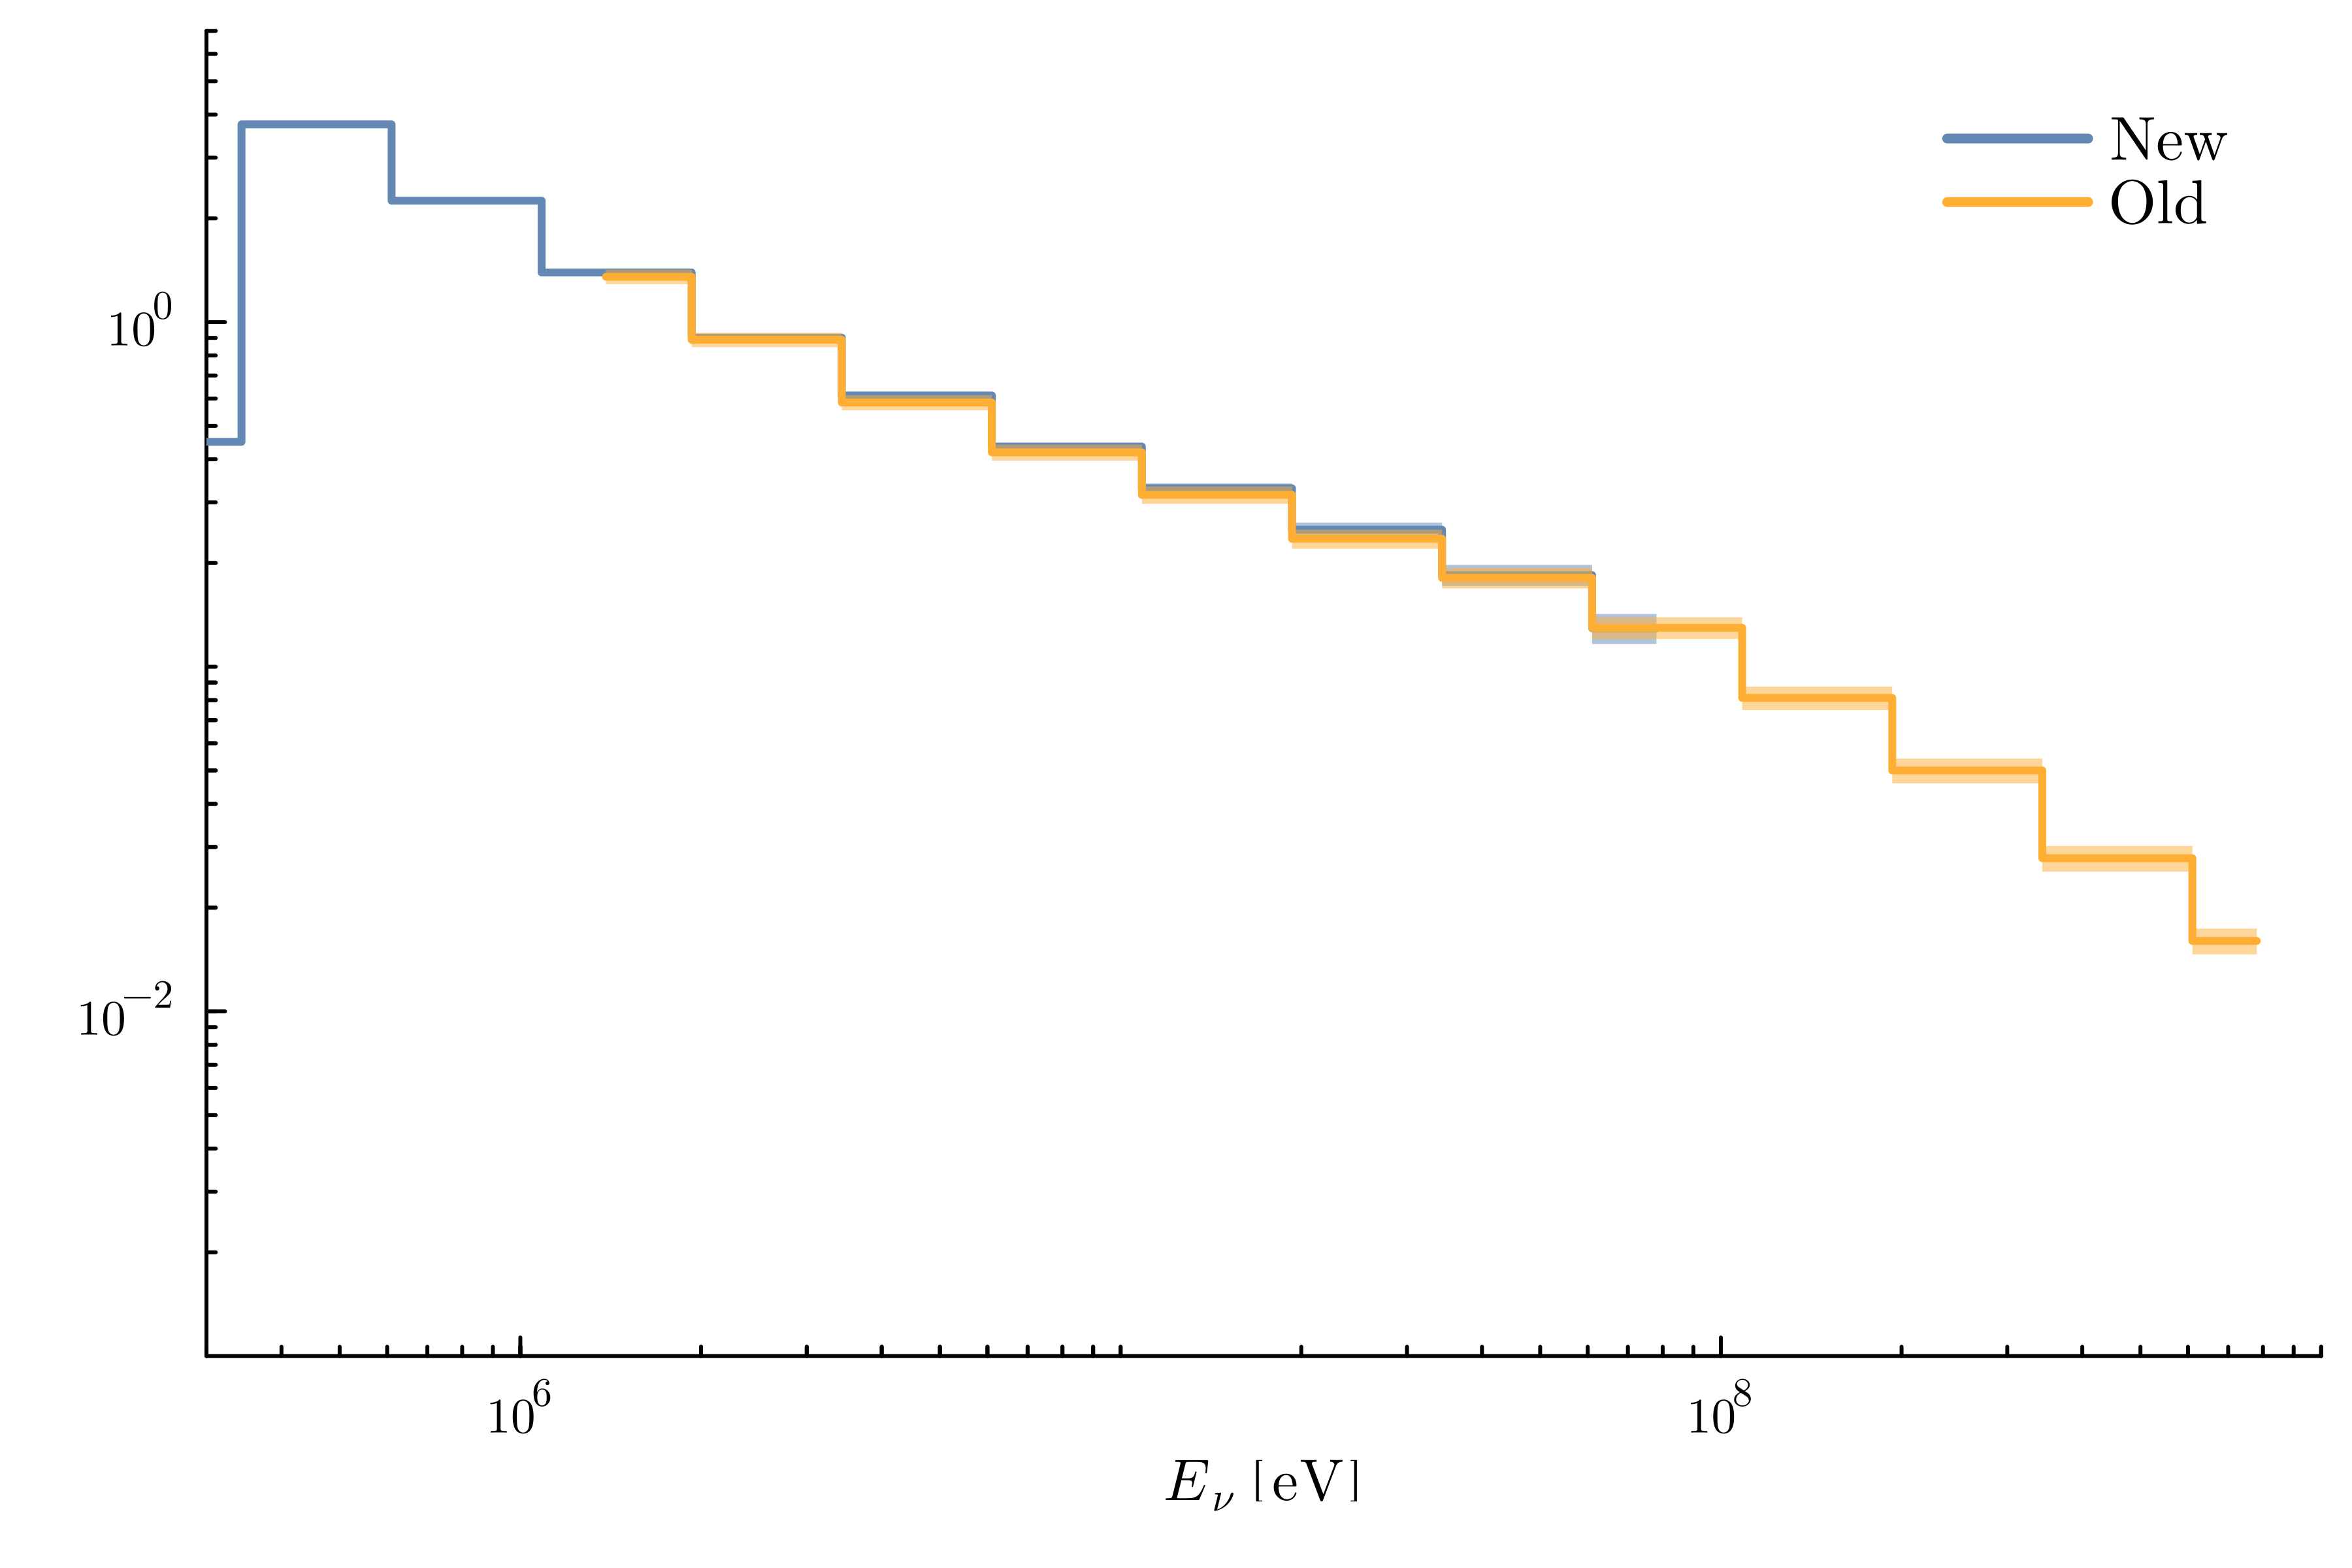

cent[m] = [0.0052117557650475255, 0.05448580868824889, 0.0507742201936237, 0.04821600196869167, 0.04535531419274746, 0.04330018413622916, 0.041401380359982184, 0.04112542495554438, 0.036538173338886634, 0.031209077607729268, 0.02478330157374613]
err[m] = [0.00028142250694152075, 0.001011069701507511, 0.0012053607419332914, 0.0014932921667061786, 0.0018842385266264515, 0.0023996103640115023, 0.003072594266052721, 0.0039624909433943825, 0.004701518210420152, 0.005284341869882075, 0.005431799864225154]
cent[m] = [0.04641486760317193, 0.04298737207924457, 0.04451923946725527, 0.04110114316340838, 0.03972162230909171, 0.03333738472479535, 0.029636783313251137, 0.02303479034814628, 0.017314744102602017, 0.01191588175571821, 0.008034317119328008, 0.0053621177024935325]
err[m] = [0.007751261664389208, 0.007320103850531042, 0.007301515896477273, 0.006913192705411307, 0.006578051937805381, 0.005691051135133096, 0.004913302447914996, 0.0037966400886773844, 0.0027500482442646603, 0.001833550870522

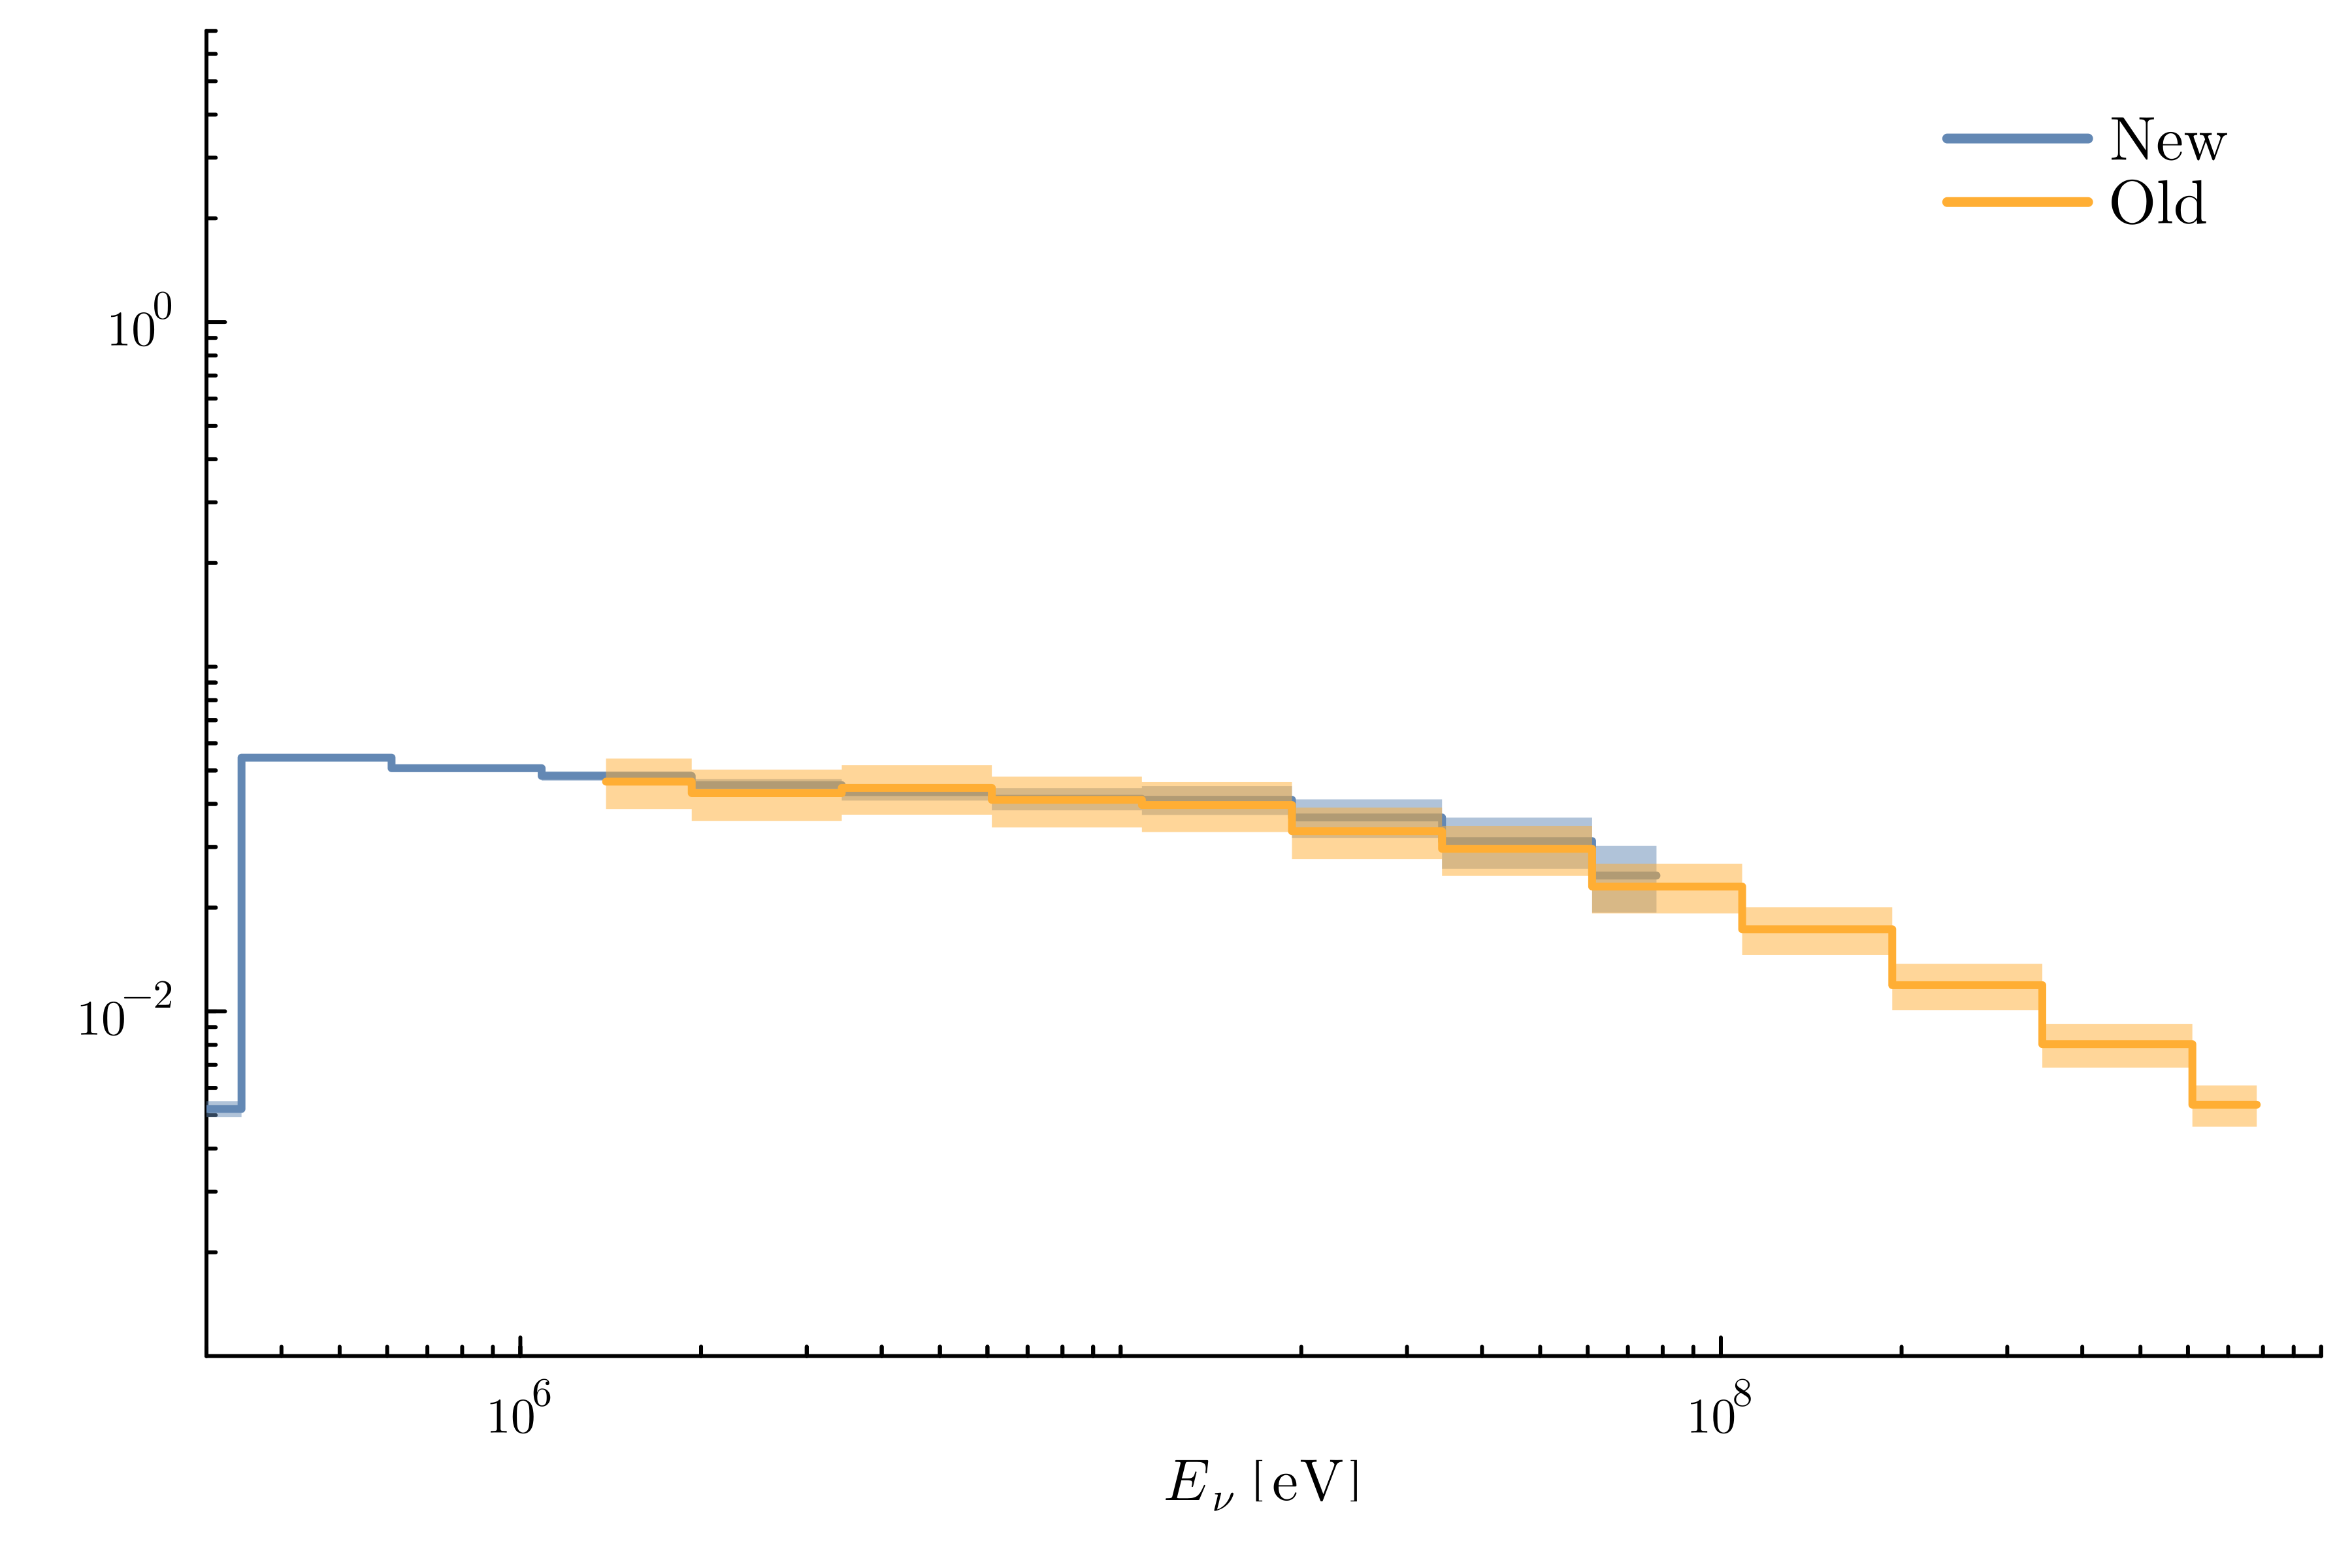

cent[m] = [0.0023692491188788333, 0.025430977796348498, 0.02530461607597448, 0.025193587139713907, 0.025389864354162017, 0.024718491378634234, 0.02365239087005594, 0.02322187352937546, 0.02019495338005333, 0.017654548145357413, 0.011759845808226478]
err[m] = [0.00020444951601211145, 0.0007362890366793133, 0.000915999730461698, 0.0011396712557751618, 0.0014846281333253022, 0.0018912339894498593, 0.002391140383559603, 0.0030463747235303235, 0.0036213959750544646, 0.004217536695082445, 0.00403085687476212]
cent[m] = [0.025506681400907928, 0.024563105253017598, 0.026951529214208087, 0.022905966151831565, 0.022542252471905378, 0.017622099609195446, 0.01598747571467927, 0.012099518164975261, 0.007864961534758942, 0.004641778328318659, 0.0026223621856741545, 0.0013166106363015479]
err[m] = [0.006191846438835904, 0.005953449127226136, 0.0059308098358553584, 0.005269944070135486, 0.0050784746634321845, 0.00424130990178081, 0.0038426625063999456, 0.0029700052635461332, 0.002035509080335476, 0.00

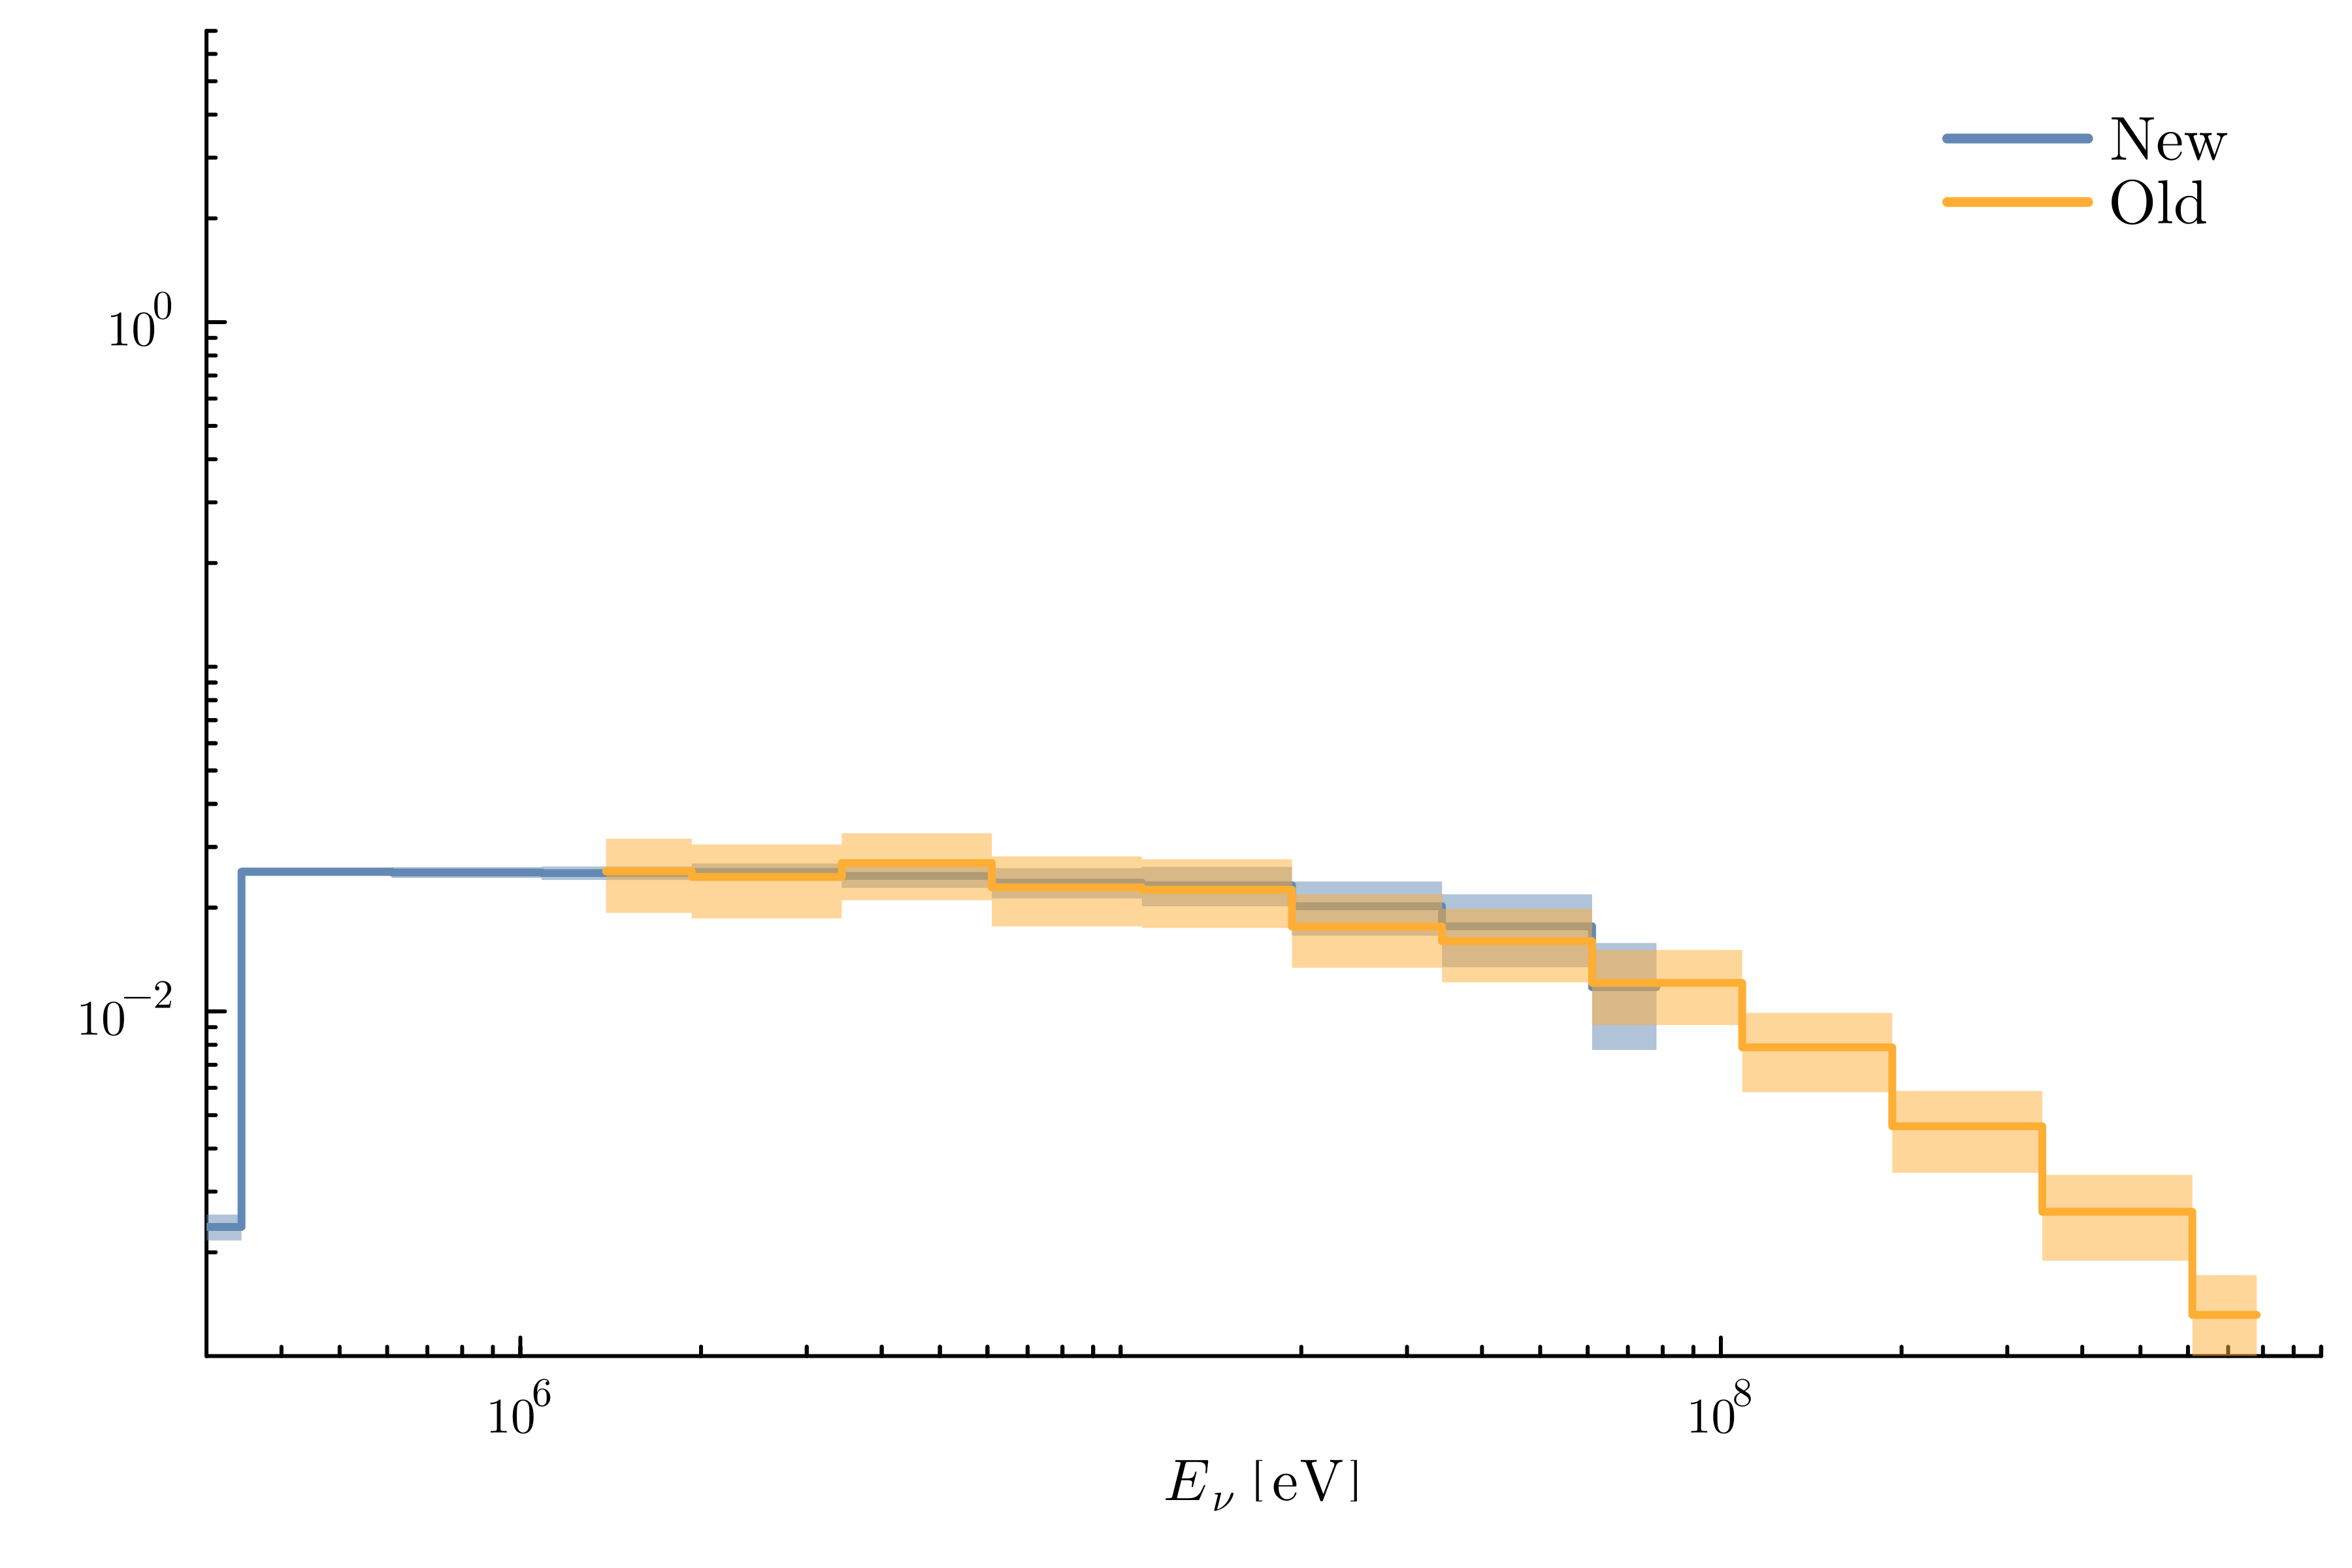

In [200]:
for jdx in 1:3

    plt = plot(
        xscale=:log10,
        yaxis=(:log10, [1e-3, 7]),
        xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
        # ylabel=L"E_{\nu}\frac{\mathrm{d}N_{\nu}}{\mathrm{d}E_{\nu}\mathrm{d}t}~\left[\mathrm{yr}^{-1}\right]",
        bottommargin=3mm,
        leftmargin=3mm,
        xlimits=(3e5, 1e9),
        size=(600, 400)
    )

    for idx in 1:2

        label = idx==1 ? "New" : "Old"

        cent = hists[idx, jdx, 1, :] * units.second * 10^7.5
        err = 5 * sqrt.(hists[idx, jdx, 2, :]) * units.second * 10^7.5
        m = cent .> 0
        @show cent[m]
        @show err[m]

        # factor = idx==1 ? 1.0 : 1.44
        
        plot!(
            plt,
            CENTS[m] ./ units.GeV,
            cent[m],
            label=label,
            ribbon=err[m],
            linetype=:stepmid
        )
    end

    display(plt)
end

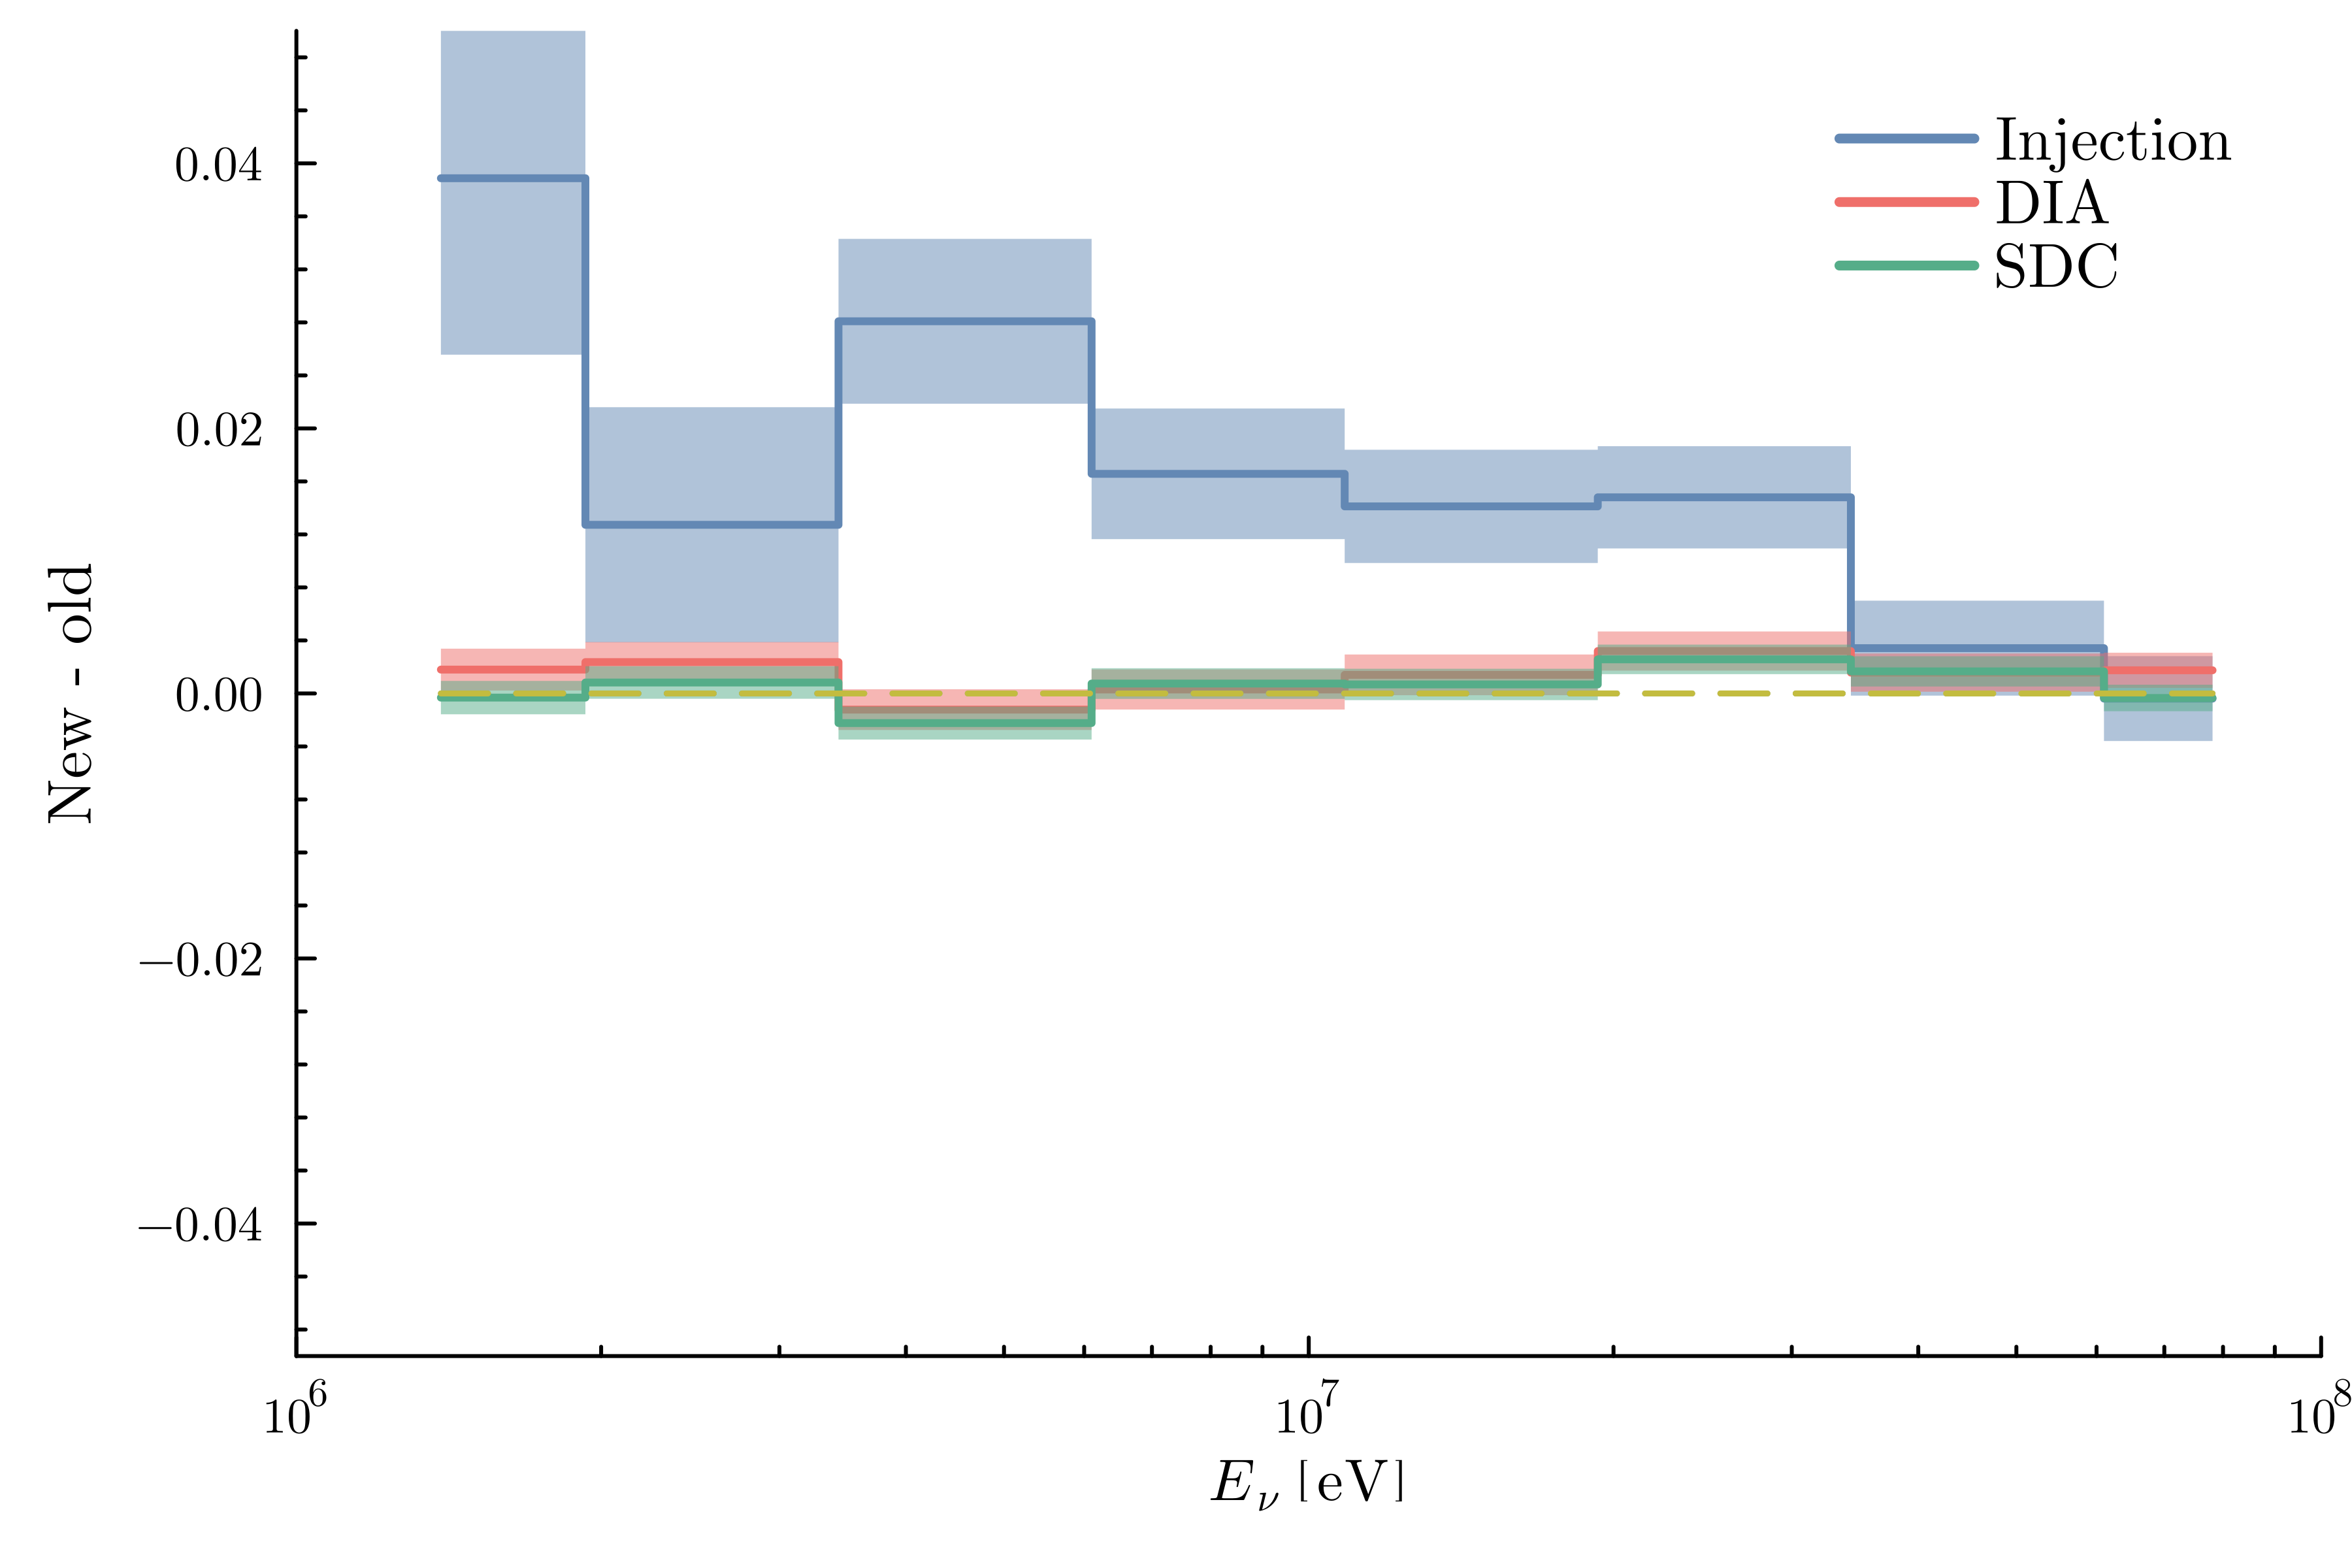

In [214]:
plt = plot(
    xscale=:log10,
    # yaxis=(:log10, [1e-3, 7]),
    xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
    ylabel="New - old",
    bottommargin=3mm,
    leftmargin=3mm,
    xlimits=(1e6, 1e8),
    ylimits=(-0.05, 0.05),
    size=(600, 400)
)

labels = ["Injection", "DIA", "SDC"]

for jdx in 1:3

    
    cent1 = hists[1, jdx, 1, :] * units.second * 10^7.5
    cent2 = hists[2, jdx, 1, :] * units.second * 10^7.5
    
    m = cent1 .> 0 .&& cent2 .> 0
    
    err = sqrt.(hists[1, jdx, 2, m] + hists[2, jdx, 2, m]) * units.second * 10^7.5

    plot!(
        plt,
        CENTS[m] ./ units.GeV,
        cent1[m] - cent2[m],
        label=labels[jdx],
        ribbon=err,
        linetype=:stepmid
    )
    
    plot!(
        plt,
        CENTS[m] ./ units.GeV,
        fill(0, size(CENTS[m])),
        lw=1.5,
        linestyle=:dash
    )

end
display(plt)

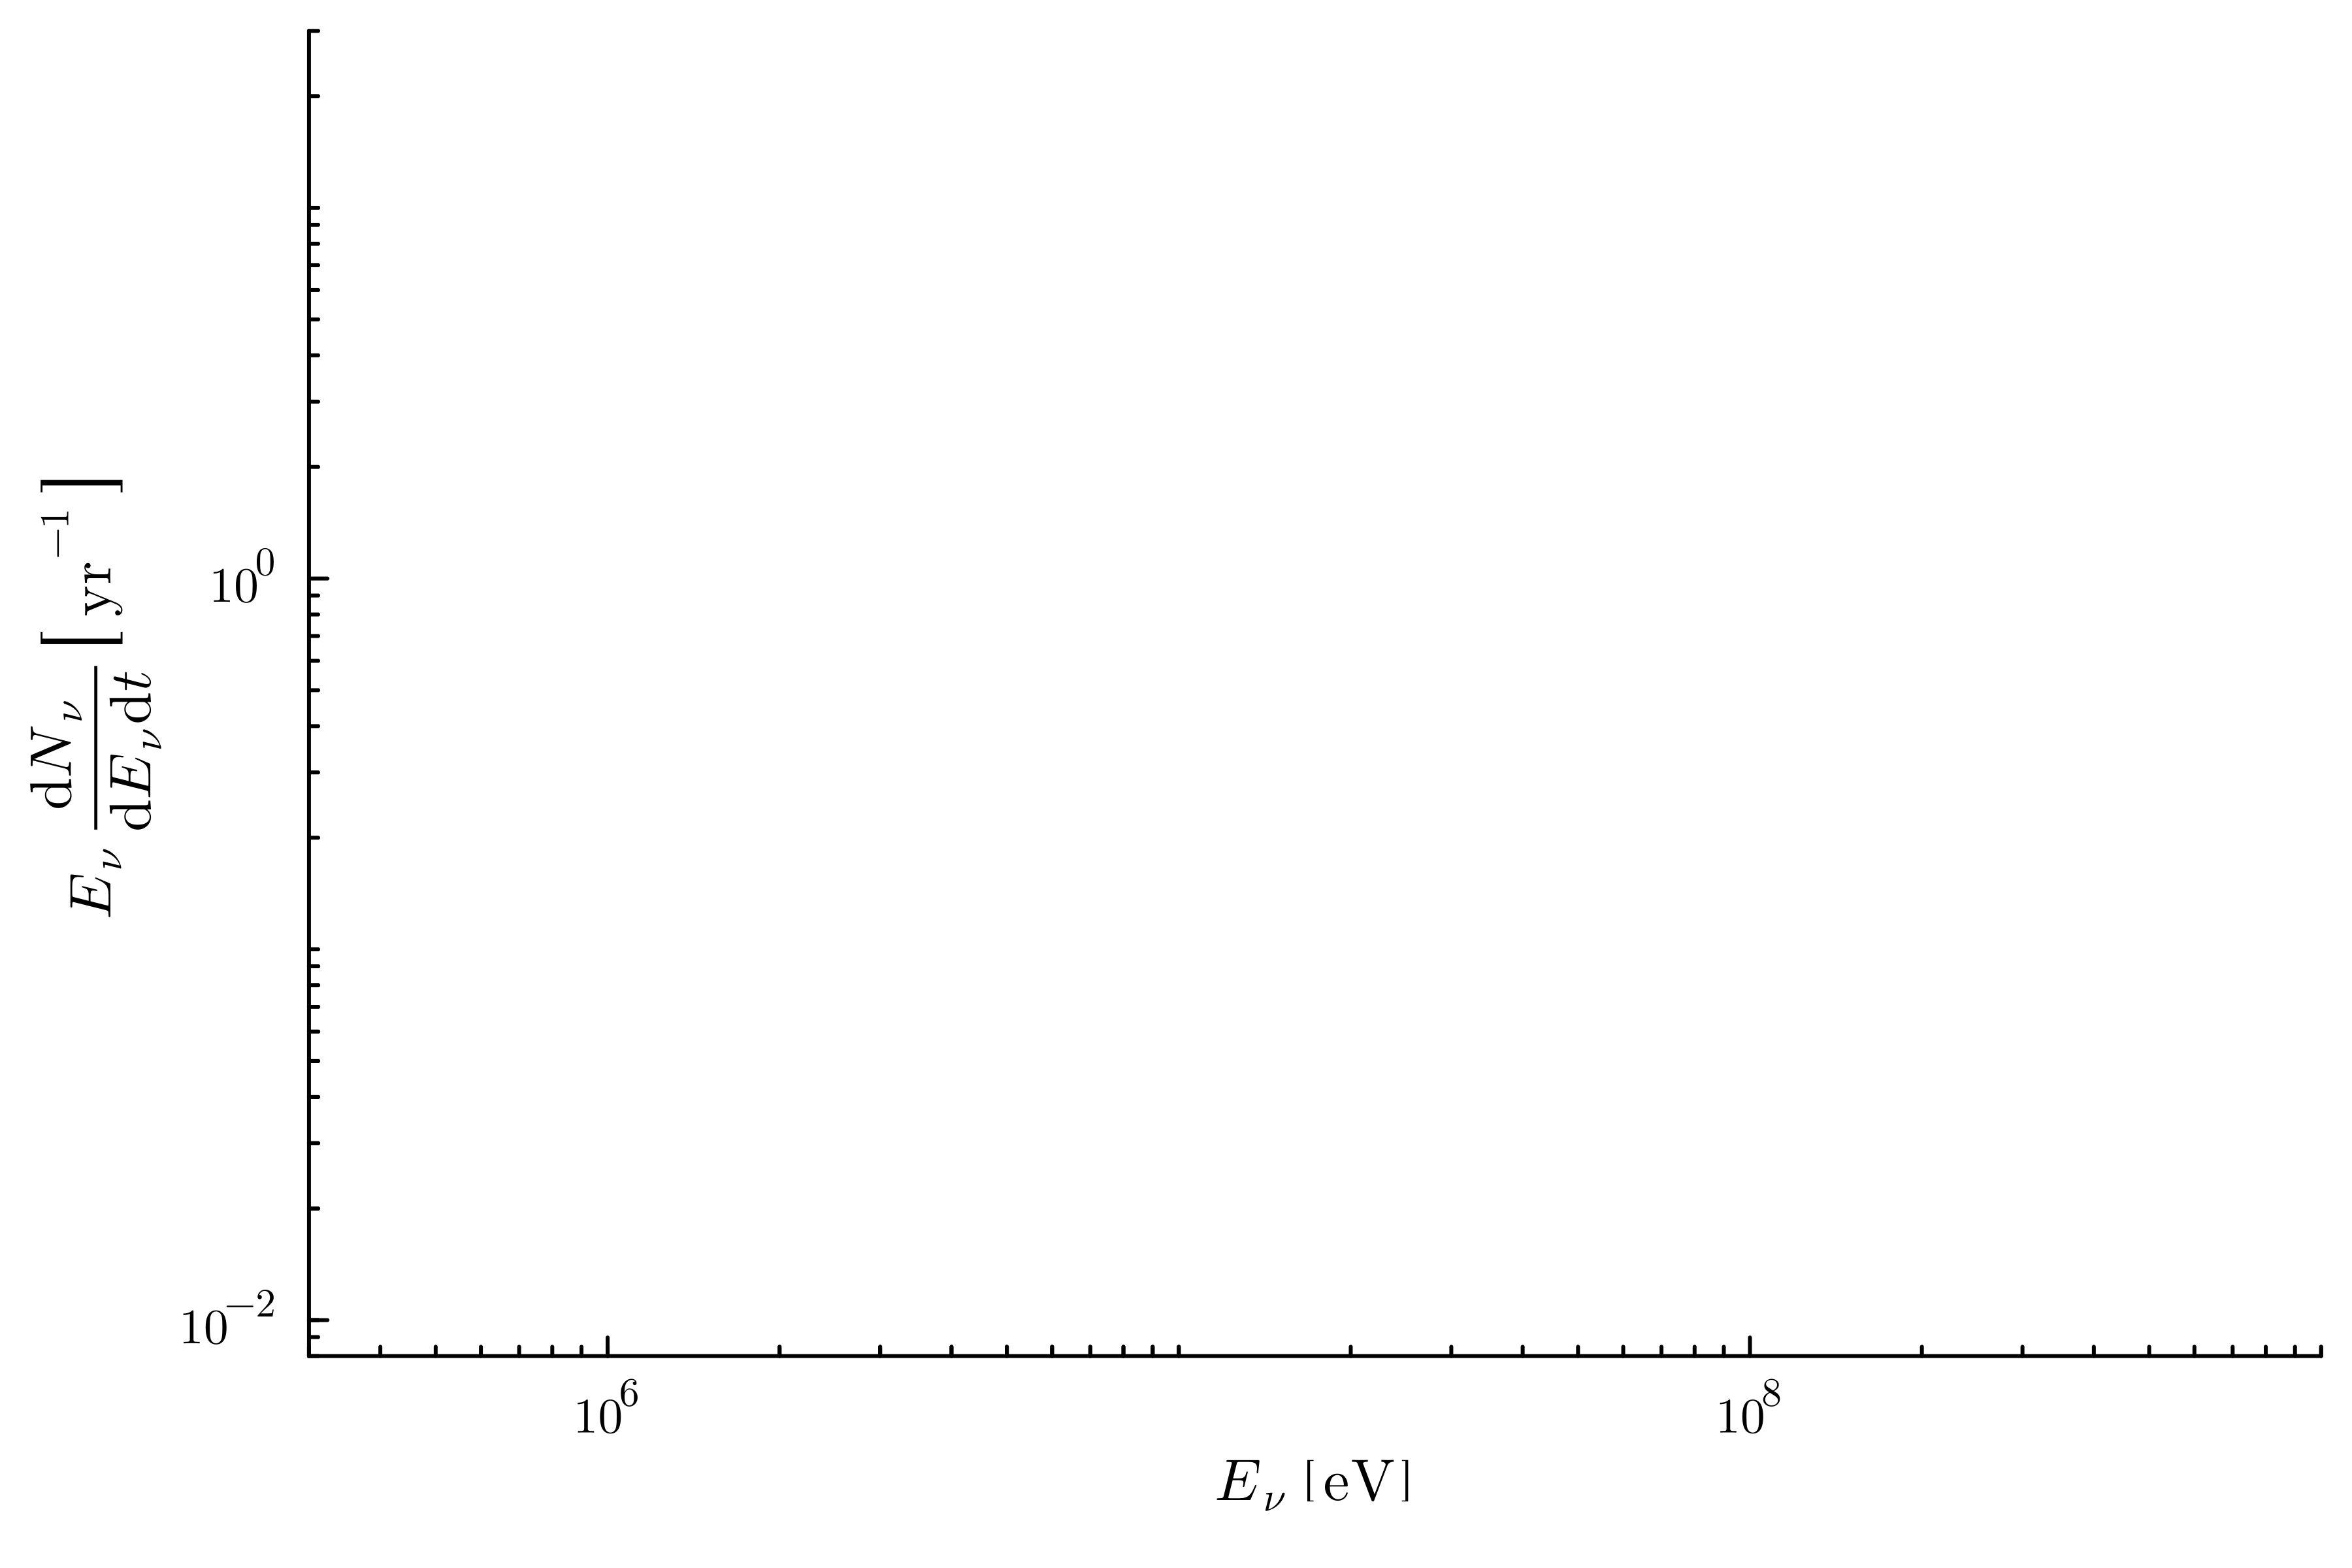

In [129]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
    ylabel=L"E_{\nu}\frac{\mathrm{d}N_{\nu}}{\mathrm{d}E_{\nu}\mathrm{d}t}~\left[\mathrm{yr}^{-1}\right]",
    bottommargin=3mm,
    leftmargin=3mm,
    xlimits=(3e5, 1e9),
    ylimits=(8e-3, 30),
    size=(600, 400)
    
)

sum(h.weights) * units.second * 10 ^ 7.5 * (5000 / nmodule) = 0.8005834939542948
sum(h.weights) * units.second * 10 ^ 7.5 * (5000 / nmodule) = 0.9417851857771813
sum(h.weights) * units.second * 10 ^ 7.5 * (5000 / nmodule) = 0.515395553843074


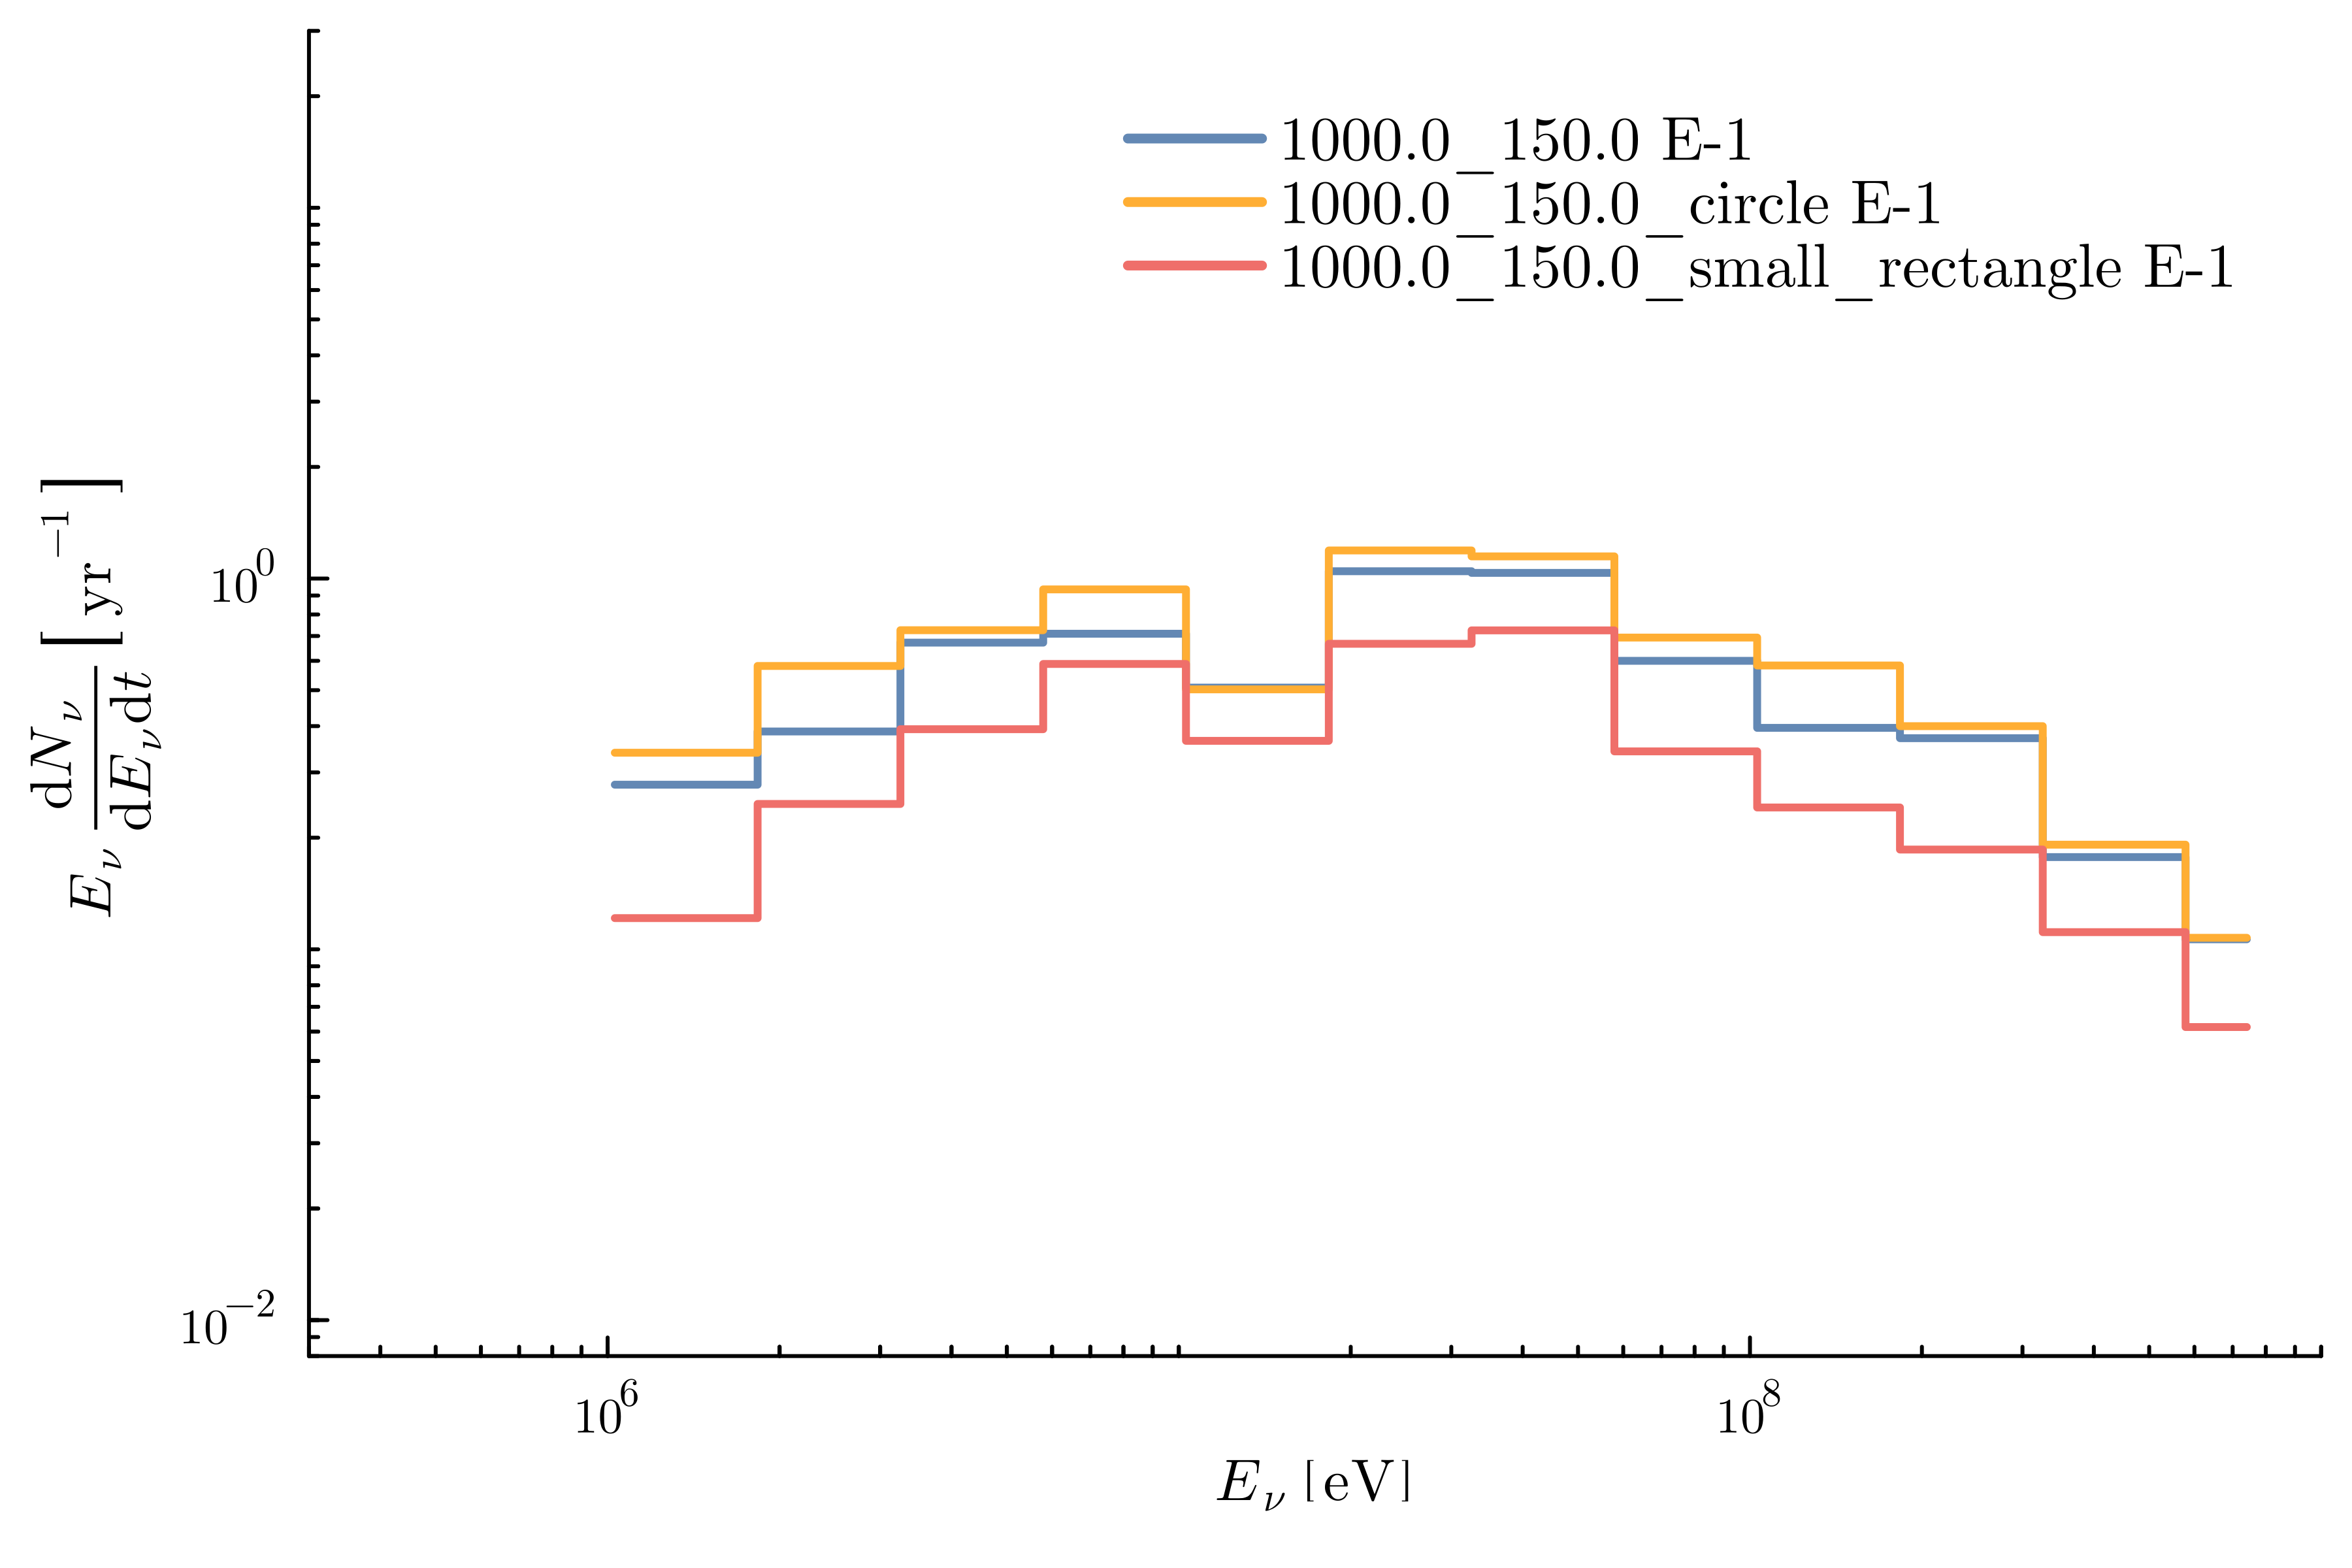

In [130]:
sim = jldopen("/Users/jlazar/Downloads/20231231_sim_filtered.jld2")
ks = [
    "1000.0_150.0",
    "1000.0_150.0_circle",
    "1000.0_150.0_small_rectangle"
]
nmodules = [200, 164, 200]

for (nmodule, key) in zip(nmodules, ks)
    events = sim[key]["injected_events"]
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    fluxes = PL.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    h = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(weights .* fluxes),
        edges
    )
    
    plot!(
        plt,
        cents/units.GeV,
        h.weights .* cents ./ widths .* units.second * 10^7.5 .* (22_000 / nmodule),
        linetype=:stepmid,
        label="$(key) E-1"
    )
    @show sum(h.weights) * units.second * 10^7.5 * (5000 / nmodule)
end
display(plt)

nmodule = 400
sum(h.weights) * units.second * 10 ^ 7.5 * (5000 / nmodule) = 0.35119374847717216


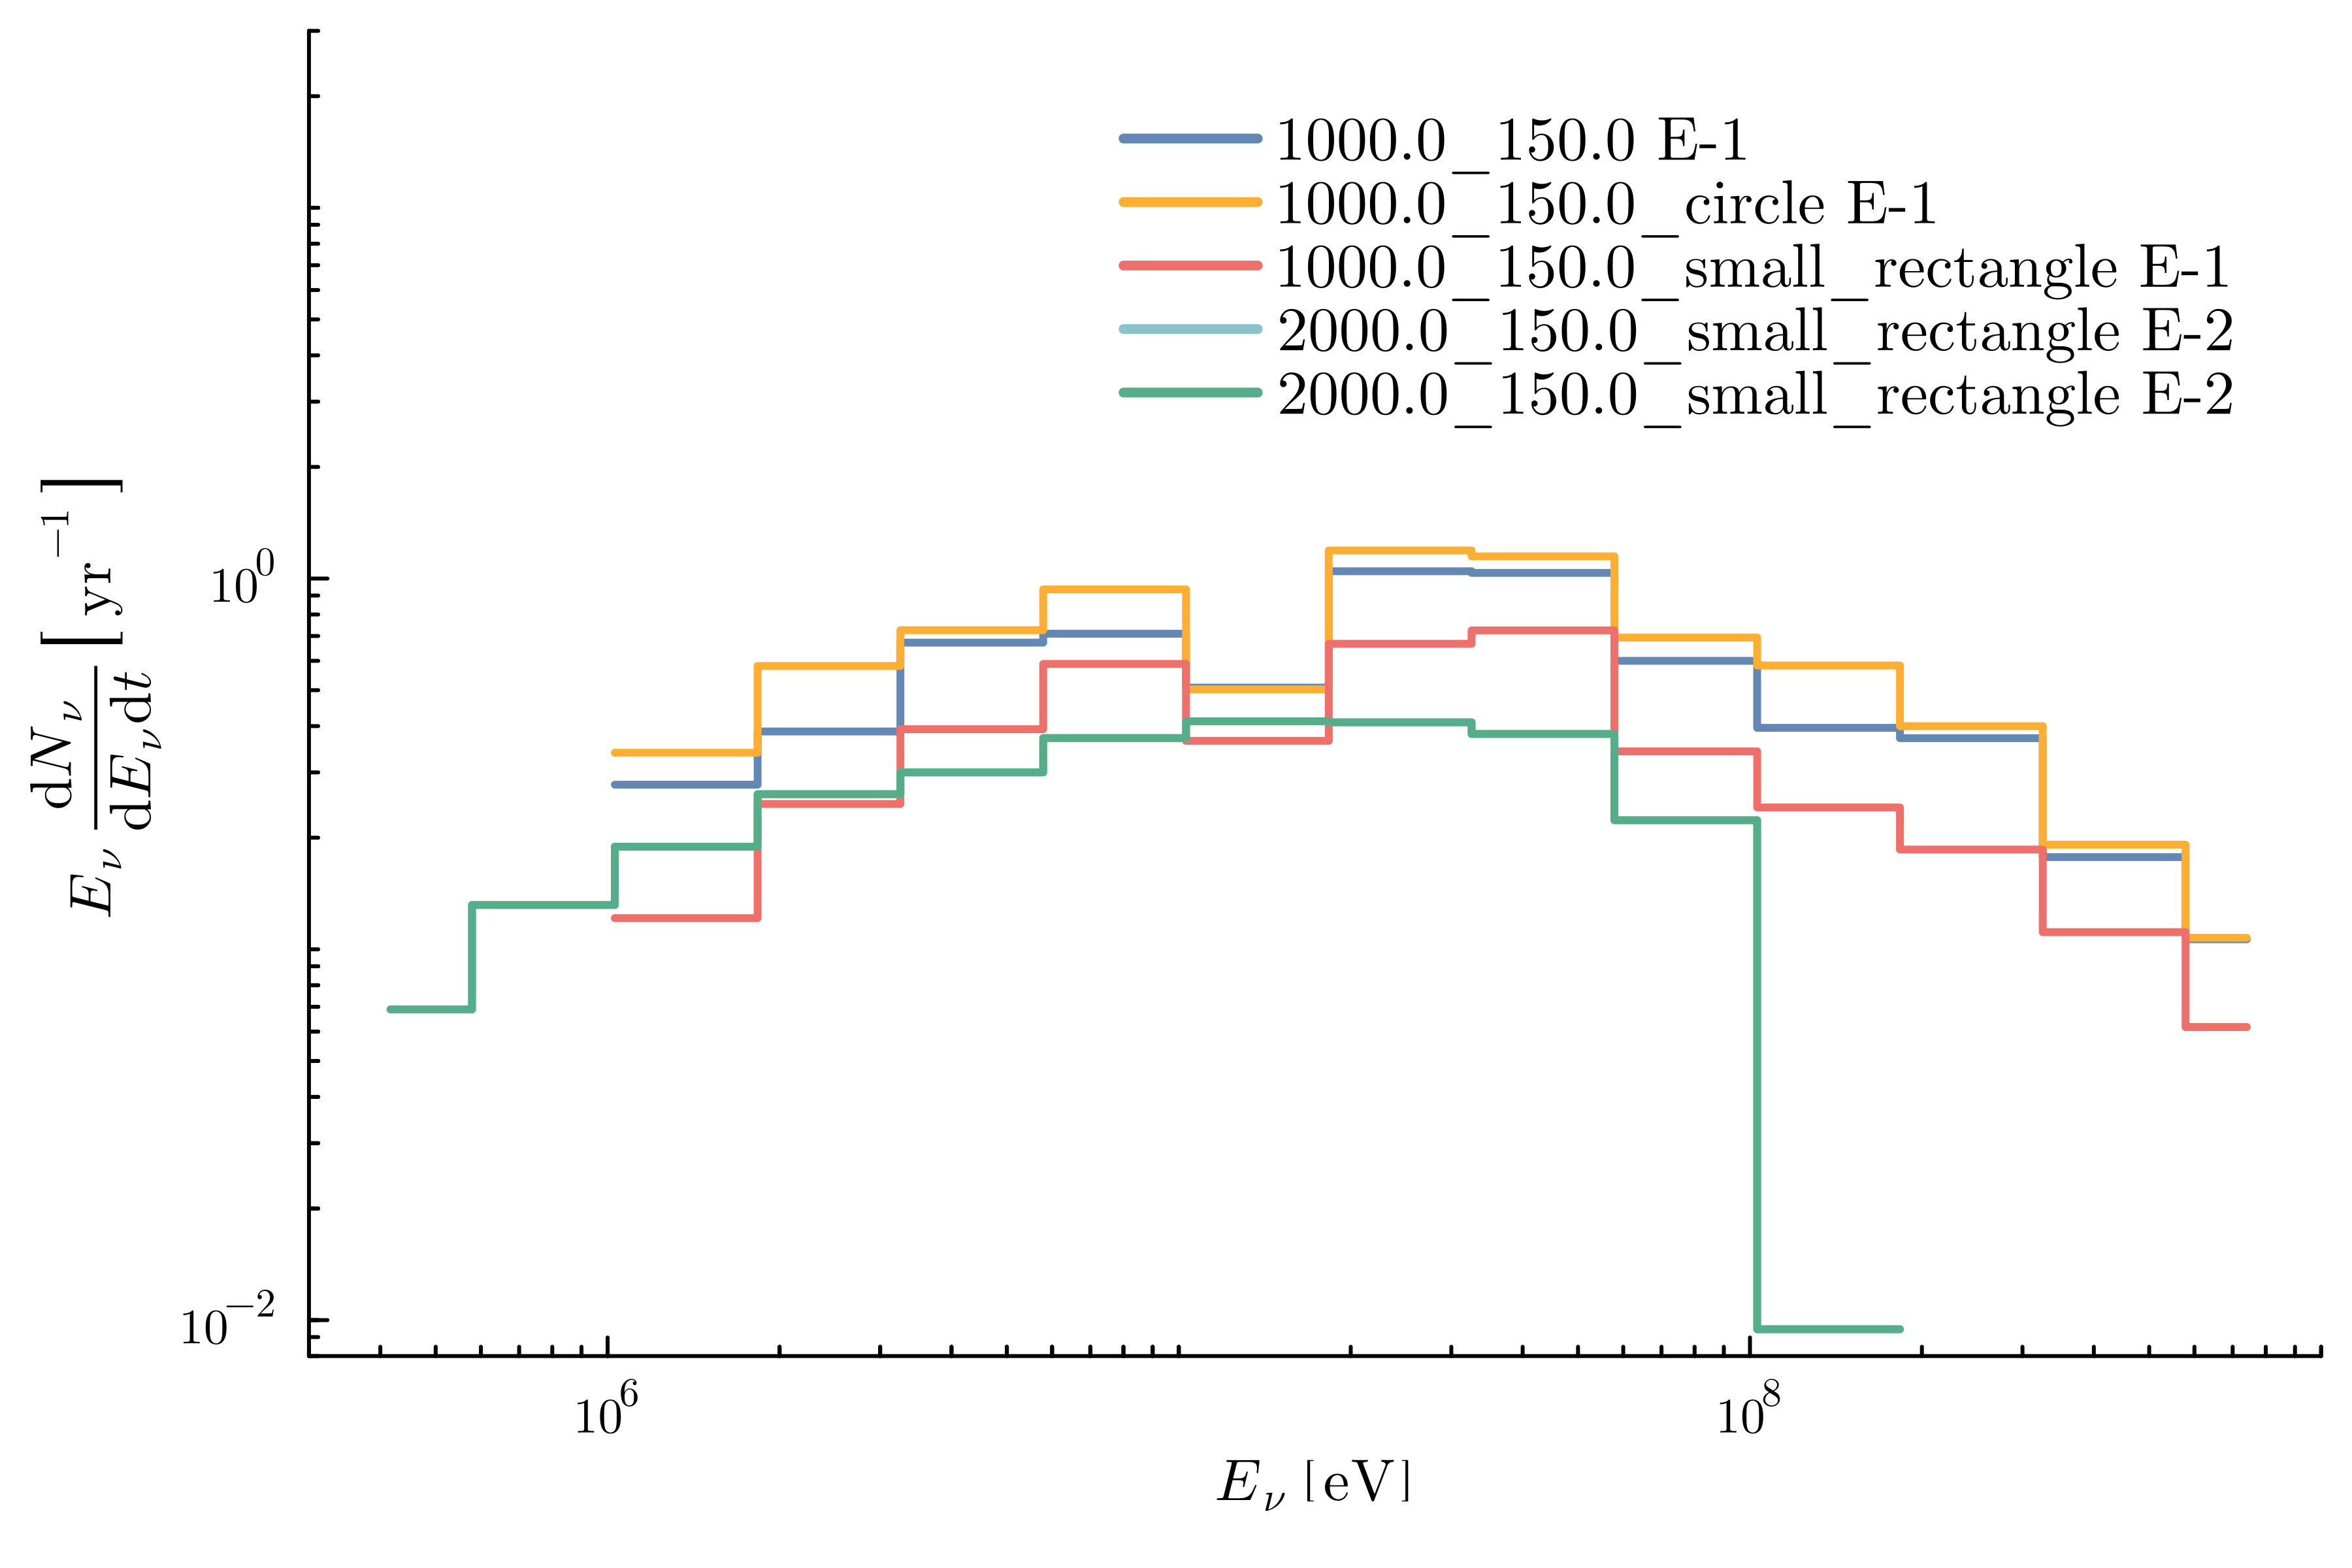

In [132]:
sim = jldopen("/Users/jlazar/Downloads/GraphNet_00000_triggered_events.jld2")

for key in keys(sim)
    if key=="config"
        continue
    end
    
    events = sim[key]["injected_events"]
    
    ℓ, Δs = parse.(Float64, split(key, "_")) .* units.m
    
    if occursin("100", key)
        continue
    end
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    nmodule = length(Tambo.make_detector_array(
        whitepaper_coord,
        ℓ,
        Δs,
        altmin,
        altmax,
        plane,
        geo
    ))
    
    @show nmodule
    
    fluxes = PL.(events["initial_state"]["energy"])
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    h = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(weights .* fluxes),
        edges
    )
    
    plot!(
        plt,
        cents/units.GeV,
        h.weights .* cents ./ widths .* units.second * 10^7.5 .* (22_000 / nmodule),
        linetype=:stepmid,
        label="$(key)_small_rectangle E-2"
    )
    
    @show sum(h.weights) * units.second * 10^7.5 * (5_000 / nmodule)
end
display(plt)

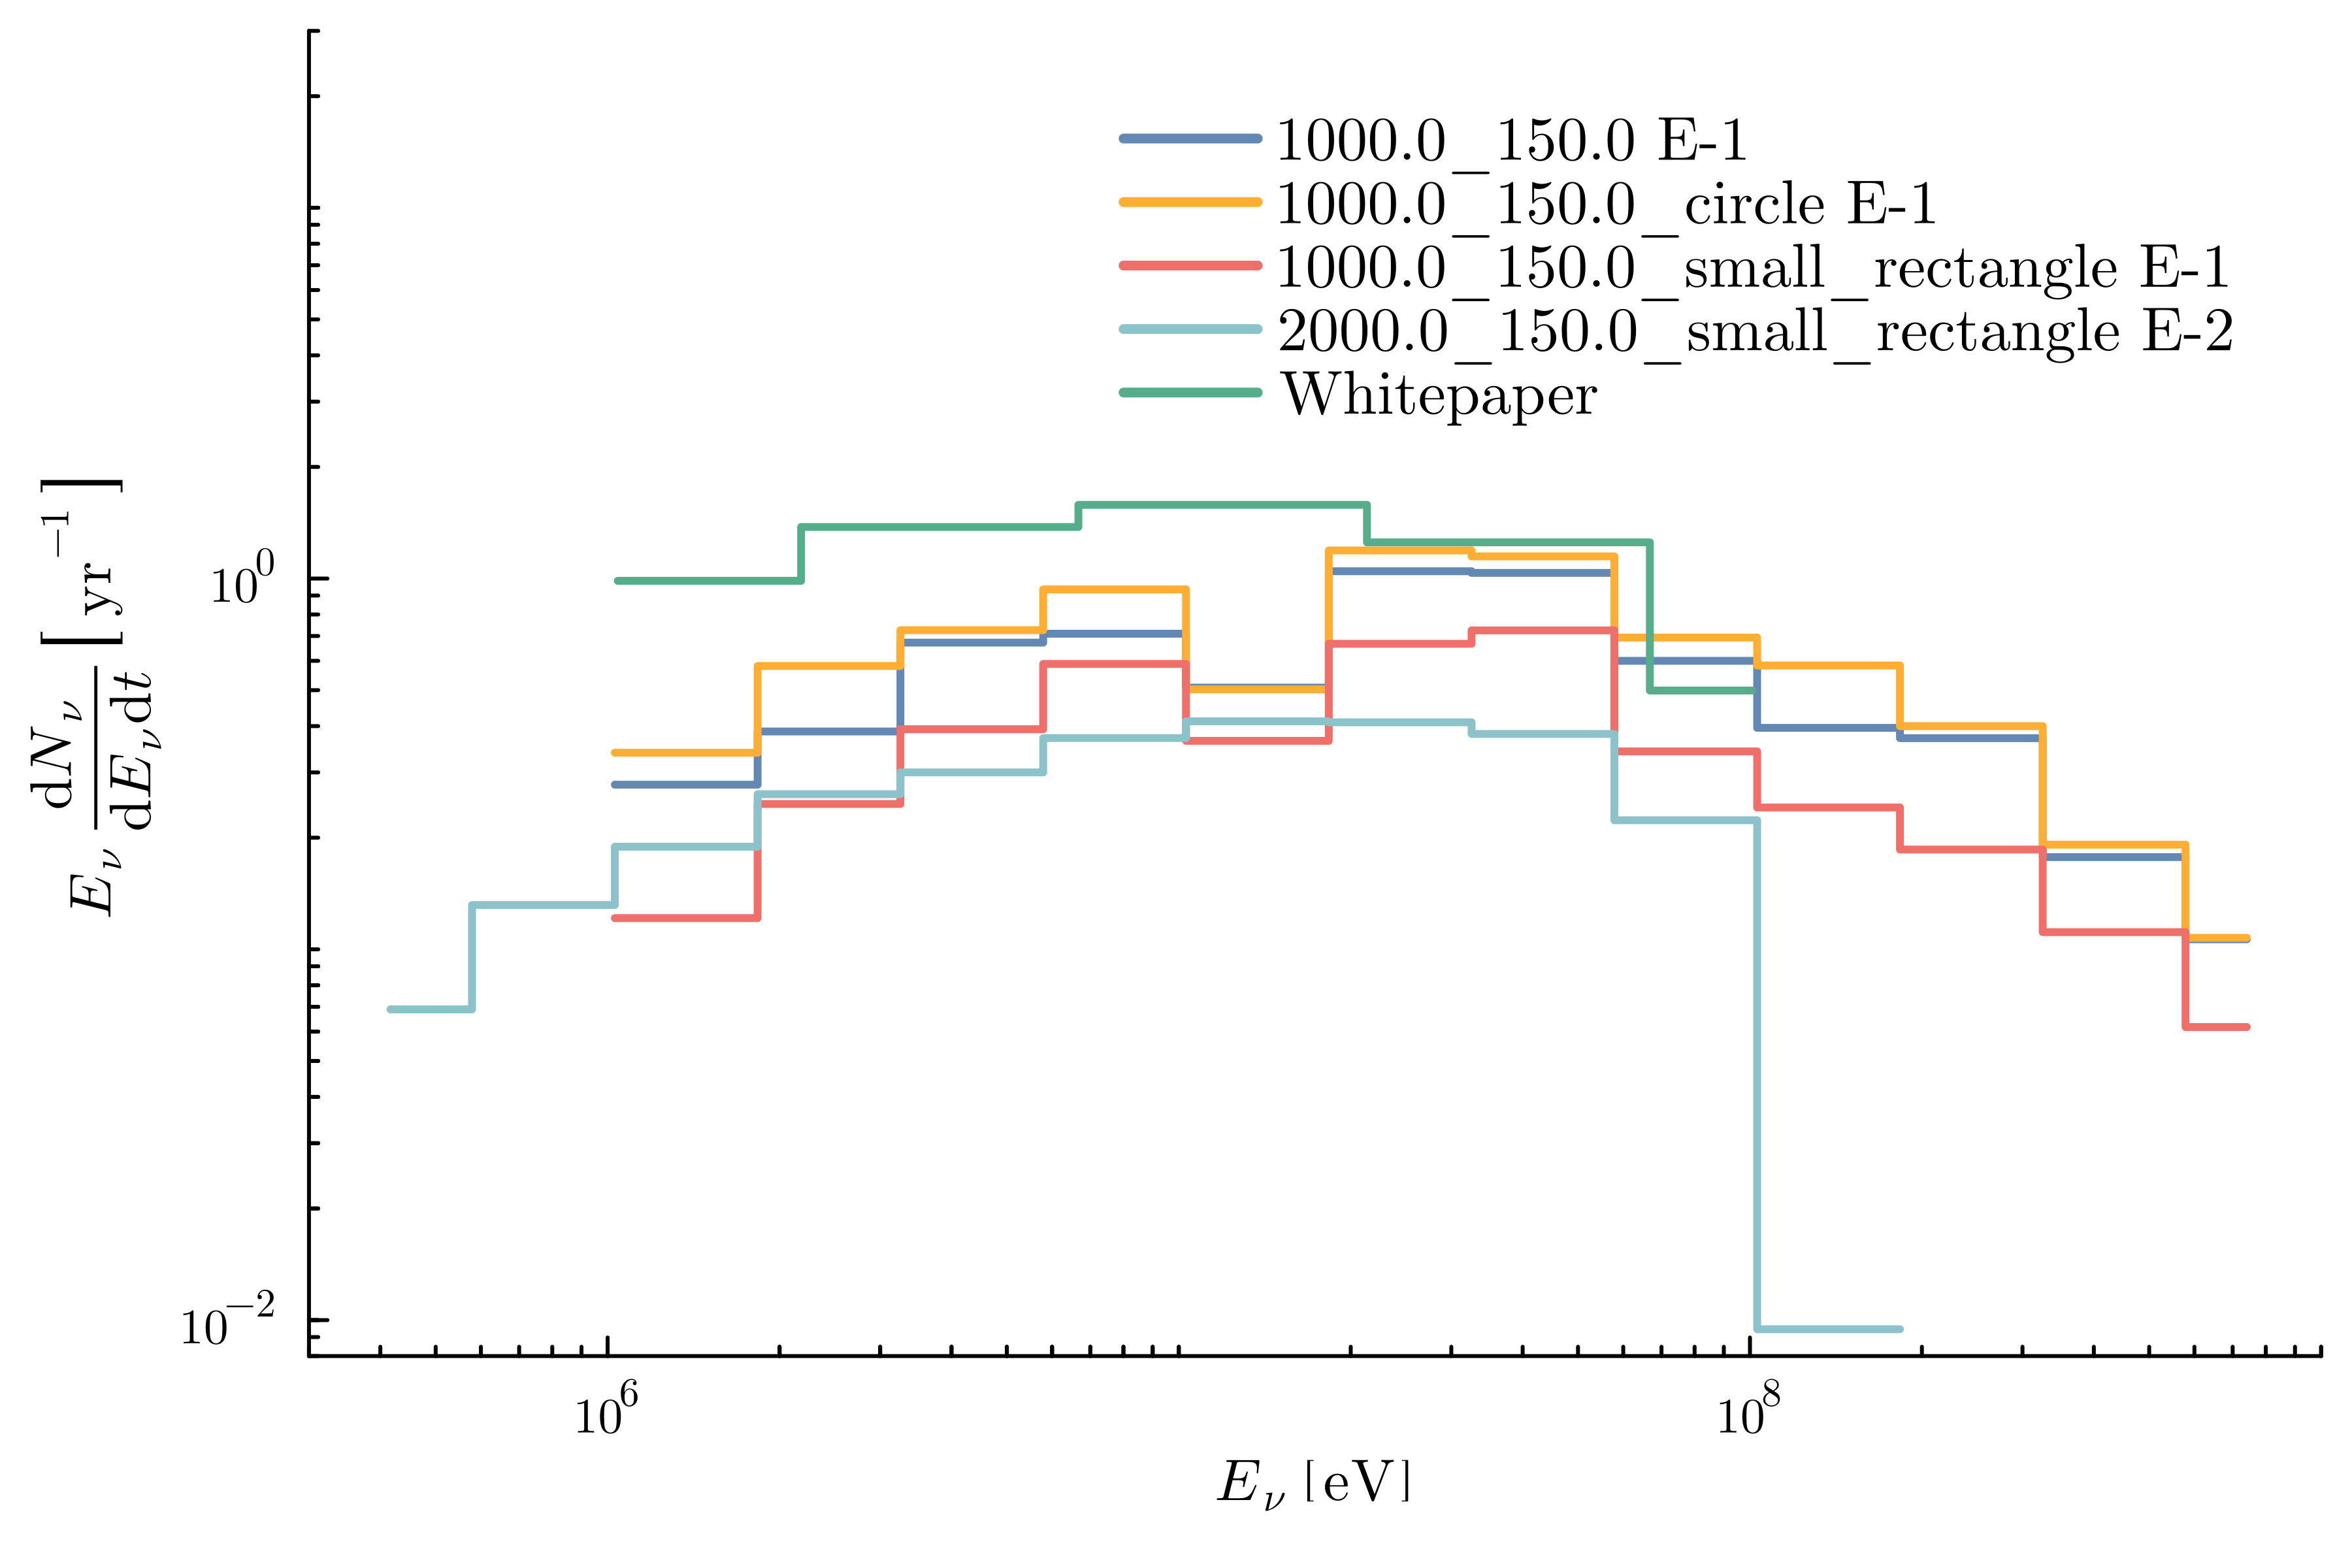

In [119]:
previous_calc = CSV.File("/Users/jlazar/Downloads/Default Dataset.csv")
digitized_prev_calc_centers = getindex.(previous_calc, 1) * units.GeV
digitized_prev_calc_rates = getindex.(previous_calc, 2) / 3

inferred_prev_calc_edges = 10 .^ (14.681:0.5:17.181)
inferred_prev_calc_cents = (inferred_prev_calc_edges[2:end] + inferred_prev_calc_edges[1:end-1]) / 2

inferred_prev_calc_widths = inferred_prev_calc_edges[2:end] - inferred_prev_calc_edges[1:end-1]

plot!(
    plt,
    digitized_prev_calc_centers / units.GeV,
    inferred_prev_calc_cents .* digitized_prev_calc_rates ./ inferred_prev_calc_widths,
    label="Whitepaper",
    linetype=:stepmid,
)

In [18]:
jldopen("/Users/jlazar/Downloads/GraphNet_00000/00000_00001/GraphNet_00000_00001.jld2") do jldf
    @show jldf["config"]
end

jldf["config"] = Dict{Symbol, Any}(:diff_xs_path => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/TAMBO-MC/resources/cross_sections/tables/csms_differential_cdfs.h5", :tablespath => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/TAMBO-MC/resources/proposal_tables", :θmin => 0.0, :n => 20000, :ϕmax => 4.031710572106901, :do_interpolate => true, :ν_pdg => 16, :r_injection => 1.013546187482e10, :emax => 1.0e17, :do_continuous => true, :ϕmin => 0.8901179185171081, :vcut => 0.01, :geo_spline_path => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/TAMBO-MC/resources/tambo_spline.jld2", :tambo_coordinates => (-15.63863°, -72.16498°), :γ => 2.0, :run_n => 853, :θmax => 2.0420352248333655, :emin => 3.0e14, :l_endcap => 5.06773093741e9, :ecut => Inf, :seed => 1970)


Dict{Symbol, Any} with 21 entries:
  :diff_xs_path      => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_sof…
  :tablespath        => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_sof…
  :θmin              => 0.0
  :n                 => 20000
  :ϕmax              => 4.03171
  :do_interpolate    => true
  :ν_pdg             => 16
  :r_injection       => 1.01355e10
  :emax              => 1.0e17
  :do_continuous     => true
  :ϕmin              => 0.890118
  :vcut              => 0.01
  :geo_spline_path   => "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_sof…
  :tambo_coordinates => (-15.63863°, -72.16498°)
  :γ                 => 2.0
  :run_n             => 853
  :θmax              => 2.04204
  :emin              => 3.0e14
  :l_endcap          => 5.06773e9
  :ecut              => Inf
  :seed              => 1970

## Let's compare the effective areas

In [118]:
θmin = deg2rad(70)
θmax = deg2rad(90)

ϕmin = deg2rad(50)
ϕmax = deg2rad(230)

Ω = (ϕmax - ϕmin) * (cos(θmin) - cos(θmax))

1.0744879696516492

length(events) = 5222


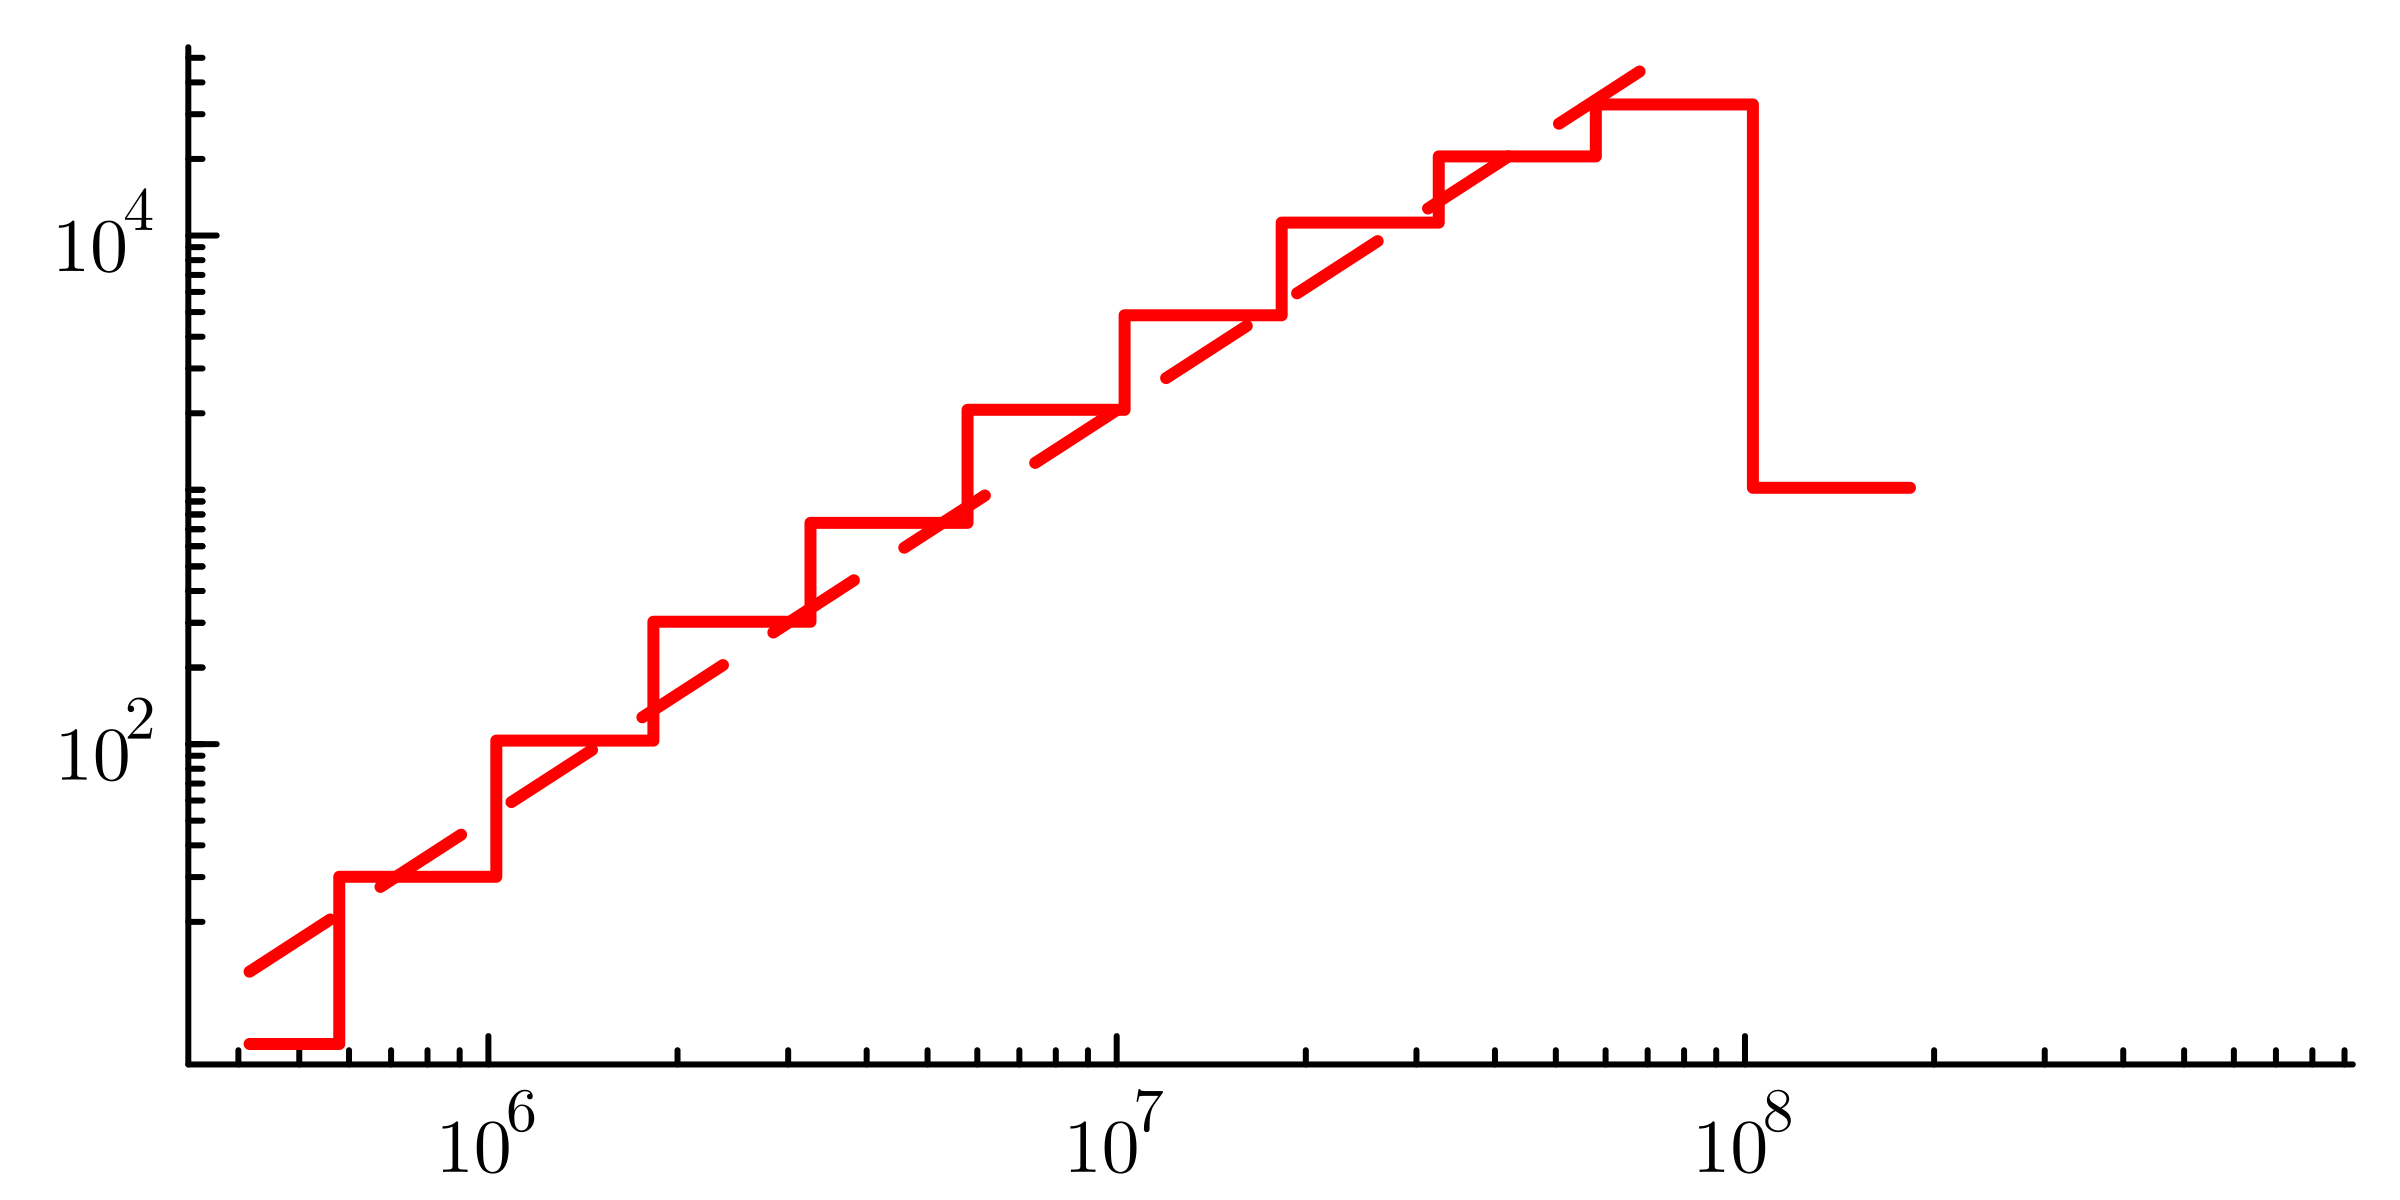

In [150]:
plt = plot(xscale=:log10, yscale=:log10, ylimits=(5.5, 55_000))

sim = jldopen("/Users/jlazar/Downloads/GraphNet_00000_triggered_events.jld2")
effa1 = nothing

for key in keys(sim)
    if occursin("100", key) || key=="config"
        continue
    end
    
    events = sim[key]["injected_events"]
    
    m = θmin .< getfield.(events["initial_state"]["direction"], :θ) .&& getfield.(events["initial_state"]["direction"], :θ) .< θmax
    events = events[m]
    @show length(events)
    
    ϕmin = getfield.(events["initial_state"]["direction"], :ϕ)
    
    ℓ, Δs = parse.(Float64, split(key, "_")) .* units.m    
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    nmodule = length(Tambo.make_detector_array(
        whitepaper_coord,
        ℓ,
        Δs,
        altmin,
        altmax,
        plane,
        geo
    ))
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    h = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(weights),
        edges
    )
    
    effa1 = h.weights ./ widths ./ Ω / nmodule
    
    plot!(
        plt,
        cents/units.GeV,
        effa1 / units.m^2 * 22_000,
        linetype=:stepmid,
        color=:red
        # label="$(key)_small_rectangle E-2"
    )
    
    plot!(
        plt,
        cents / units.GeV,
        32 * (cents / cents[2]) .^ 1.6,
        linestyle=:dash,
        color=:red
    )
    
end

display(plt)

length(events) = 297
((h.weights ./ widths) / units.m ^ 2) * (22000 / nmodule) = [0.0, 0.0, 91.93348483004203, 366.71150876256837, 1612.5048328301434, 4773.393992794753, 5902.19914109748, 26557.868847098853, 55813.759079884934, 56972.91350054043, 89476.57632244895, 162263.38271141003, 202149.96554970896, 230875.59130843412]


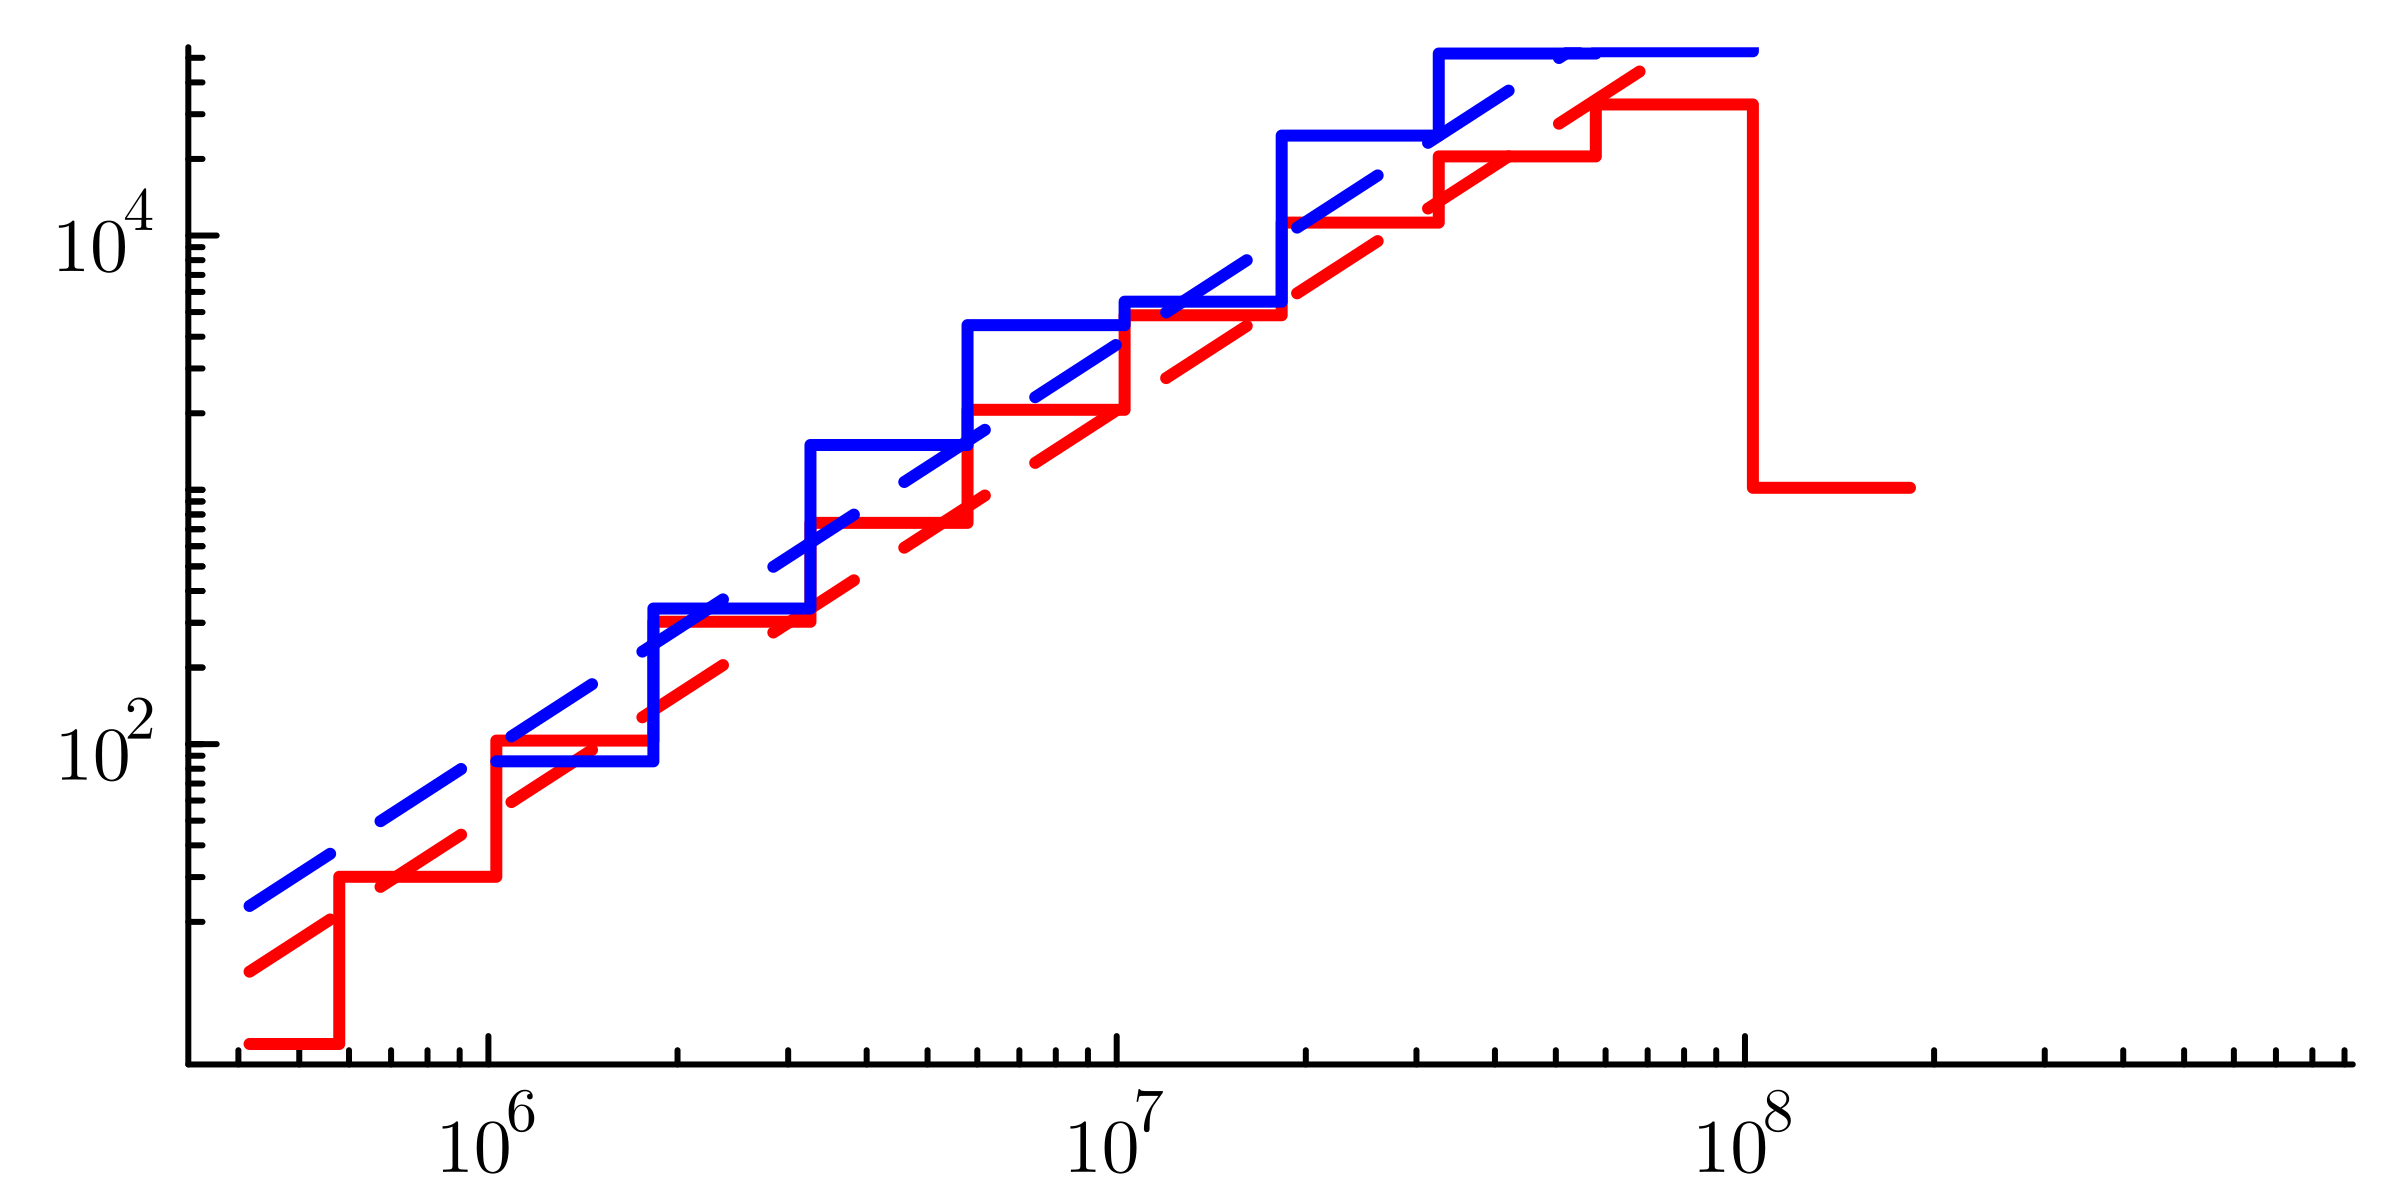

In [151]:
sim = jldopen("/Users/jlazar/Downloads/20231231_sim_filtered.jld2")
ks = [
    # "1000.0_150.0",
    # "1000.0_150.0_circle",
    "1000.0_150.0_small_rectangle"
]
nmodules = [200, 164, 200]

effa2 = nothing

for (nmodule, key) in zip(nmodules, ks)
    if key=="config"
        continue
    end
    
    events = sim[key]["injected_events"]
    
    m = θmin .< getfield.(events["initial_state"]["direction"], :θ) .&& getfield.(events["initial_state"]["direction"], :θ) .< θmax
    events = events[m]
    @show length(events)
    
    ϕmin = getfield.(events["initial_state"]["direction"], :ϕ)
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / config.n
    
    h = fit(
        Histogram,
        events["initial_state"]["energy"],
        Weights(weights),
        edges
    )
    
    effa2 = h.weights ./ widths ./ Ω / nmodule
    
    plot!(
        plt,
        cents/units.GeV,
        effa2 / units.m^2 * 22_000,
        linetype=:stepmid,
        color=:blue
        # label="$(key)_small_rectangle E-2"
    )
    
    plot!(
        plt,
        cents / units.GeV,
        366 * (cents / cents[4]) .^ 1.6,
        color=:blue,
        linestyle=:dash
    )
    
    @show h.weights ./ widths / units.m^2 * (22_000 / nmodule)
end

display(plt)

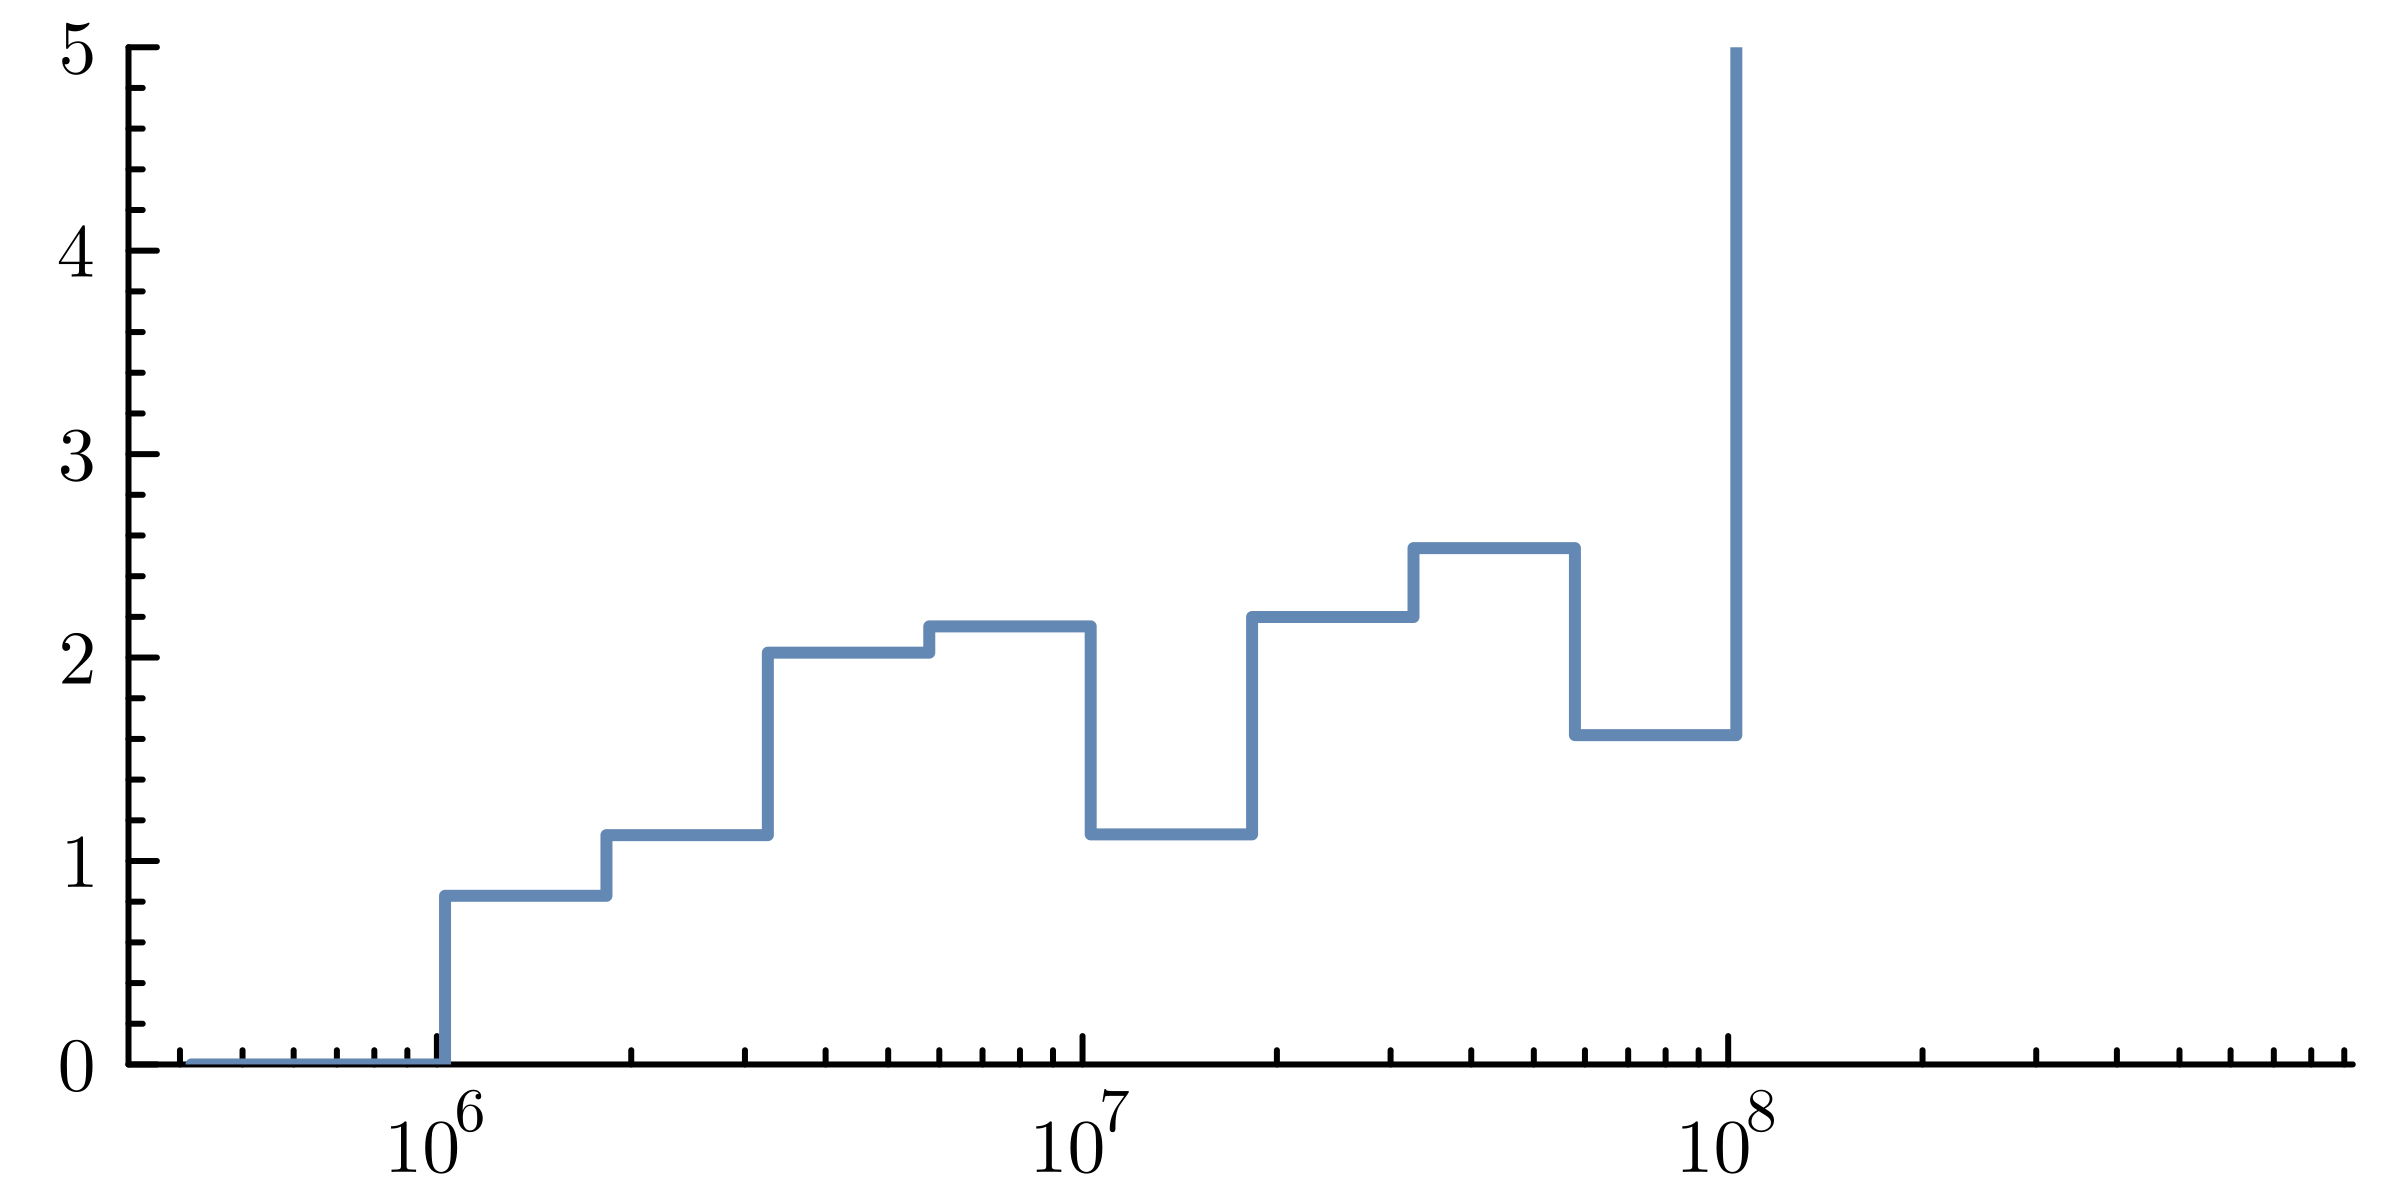

In [156]:
plot(cents / units.GeV, effa2 ./ effa1, xscale=:log10, linetype=:stepmid, ylims=(0, 5))